# Traditional ML Pipeline for Multi-label Emotion Classification

## Project Overview
- **Dataset**: GoEmotions - 58k Reddit comments with 28 emotion labels
- **Task**: Multi-label emotion classification 
- **Approach**: Traditional ML with comprehensive feature engineering
- **Key Features**:
  - Advanced text preprocessing with Reddit-specific handling
  - TF-IDF + Character n-grams + 56 linguistic features
  - Multiple ML algorithms with convergence checking
  - Threshold optimization for each emotion
  - Comprehensive error analysis

## Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Configuration](#2-configuration)
3. [Data Loading & Exploration](#3-data-loading)
4. [Text Preprocessing](#4-preprocessing)
5. [Feature Engineering](#5-features)
6. [Model Training](#6-training)
7. [Evaluation & Analysis](#7-evaluation)
8. [Model Persistence](#8-saving)
9. [Inference Pipeline](#9-inference)

## 1. Environment Setup
Import all necessary libraries and set random seeds for reproducibility.

In [6]:
# ==============================
# Environment Setup and Imports
# ==============================

# System and path management
import sys
import os
import warnings
# warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Data manipulation and numerical computing
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix

# Text processing and NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD

# ML Models
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss, jaccard_score, classification_report,
    multilabel_confusion_matrix, coverage_error, label_ranking_loss
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Utilities
from tqdm import tqdm
import json
import pickle
import joblib
from datetime import datetime
from collections import Counter

# Progress bar for pandas
tqdm.pandas()

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Environment setup complete!")
print(f"📍 Current working directory: {os.getcwd()}")
print(f"📍 Project root: {os.path.dirname(os.getcwd())}")

✅ Environment setup complete!
📍 Current working directory: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\notebooks
📍 Project root: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project


In [7]:
# ============================
# Download Required NLTK Data
# ============================

# Download NLTK resources
nltk_packages = [
    'punkt',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'vader_lexicon',
    'omw-1.4'
]

print("📥 Downloading NLTK packages...")
for package in nltk_packages:
    try:
        nltk.data.find(f'tokenizers/{package}')
        print(f"  ✓ {package} already downloaded")
    except LookupError:
        print(f"  ⬇ Downloading {package}...")
        nltk.download(package, quiet=True)

print("\n✅ All NLTK packages ready!")

📥 Downloading NLTK packages...
  ✓ punkt already downloaded
  ⬇ Downloading stopwords...
  ⬇ Downloading wordnet...
  ⬇ Downloading averaged_perceptron_tagger...
  ⬇ Downloading vader_lexicon...
  ⬇ Downloading omw-1.4...

✅ All NLTK packages ready!


## 2. Configuration
Central configuration class containing all pipeline parameters. Modify these settings to customize the pipeline behavior.

In [8]:
# ====================
# Configuration Class
# ====================

class Config:
    """Configuration settings for Traditional ML pipeline"""
    
    # Project structure
    PROJECT_ROOT = os.path.dirname(os.getcwd())  # Parent of notebooks/
    
    # Data paths
    DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
    DATA_PATH = os.path.join(DATA_DIR, 'go_emotions_dataset.csv')
    
    # Check if data exists
    if not os.path.exists(DATA_PATH):
        print(f"⚠️ Dataset not found at: {DATA_PATH}")
        print("Please download the GoEmotions dataset and place it in the data/ directory")
        # Provide download link
        print("\nDownload from: https://github.com/google-research/google-research/tree/master/goemotions")
    
    # Model output paths
    MODEL_DIR = os.path.join(PROJECT_ROOT, 'models', 'traditional_ml')
    RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results', 'traditional_ml_results')
    
    # Create directories if they don't exist
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # Data parameters
    USE_FULL_DATASET = True  # Use entire dataset
    SAMPLE_SIZE = None  # Set to number if you want to use subset
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    
    # Text preprocessing parameters
    MIN_TEXT_LENGTH = 2  # CHANGED from 3 to 2
    MAX_TEXT_LENGTH = 512
    REMOVE_STOPWORDS = True
    USE_LEMMATIZATION = True
    USE_STEMMING = False  # Don't use both lemmatization and stemming
    REMOVE_NUMBERS = True
    
    # Feature extraction parameters
    TFIDF_PARAMS = {
        'max_features': 10000,
        'ngram_range': (1, 3),  # unigrams, bigrams, trigrams
        'min_df': 2,
        'max_df': 0.95,
        'use_idf': True,
        'smooth_idf': True,
        'sublinear_tf': True,
        'norm': 'l2'
    }
    
    # Character n-gram parameters
    CHAR_PARAMS = {
        'analyzer': 'char',
        'ngram_range': (3, 5),
        'max_features': 2000,
        'min_df': 2
    }
    
    # Model training parameters
    USE_CLASS_WEIGHTS = True
    USE_MULTIOUTPUT = True  # For multi-label classification
    CV_FOLDS = 5  # Cross-validation folds
    CHECK_CONVERGENCE = True  # NEW
    
    # Feature engineering flags
    USE_LINGUISTIC_FEATURES = True
    USE_SENTIMENT_FEATURES = True
    USE_CHAR_NGRAMS = True
    
    # Performance optimization
    N_JOBS = -1  # Use all CPU cores
    VERBOSE = 1
    
    # Emotion categories
    EMOTION_COLUMNS = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
        'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
        'pride', 'realization', 'relief', 'remorse', 'sadness',
        'surprise', 'neutral'
    ]

# Initialize configuration
config = Config()
print("\n✅ Configuration loaded!")
print(f"📁 Model directory: {config.MODEL_DIR}")
print(f"📁 Results directory: {config.RESULTS_DIR}")


✅ Configuration loaded!
📁 Model directory: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml
📁 Results directory: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\results\traditional_ml_results


## 3. Data Loading and Exploration
Load the GoEmotions dataset and perform initial exploratory data analysis.

In [9]:
# ==============================
#  Data Loading and Exploration
# ==============================

def load_goemotions_dataset(config):
    """
    Load and explore the GoEmotions dataset
    
    Args:
        config: Configuration object
        
    Returns:
        df: DataFrame with the dataset
        emotion_columns: List of emotion column names
    """
    print("📊 Loading GoEmotions dataset...")
    
    # Check if file exists
    if not os.path.exists(config.DATA_PATH):
        raise FileNotFoundError(f"Dataset not found at {config.DATA_PATH}")
    
    # Load data
    df = pd.read_csv(config.DATA_PATH)
    print(f"✅ Loaded {len(df):,} samples")
    
    # Identify emotion columns
    emotion_columns = config.EMOTION_COLUMNS
    
    # Basic statistics
    print("\n📈 Dataset Statistics:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Number of emotions: {len(emotion_columns)}")
    print(f"  Columns: {list(df.columns)}")
    
    # Remove unclear examples if column exists
    if 'example_very_unclear' in df.columns:
        unclear_count = df['example_very_unclear'].sum()
        df = df[df['example_very_unclear'] == False].copy()
        print(f"\n🧹 Removed {unclear_count:,} unclear examples")
        print(f"✅ Clean samples: {len(df):,}")
    
    # Check for missing values
    missing_text = df['text'].isna().sum()
    if missing_text > 0:
        print(f"\n⚠️ Found {missing_text} missing texts, removing...")
        df = df[df['text'].notna()].copy()
    
    # Text length statistics
    text_lengths = df['text'].str.len()
    print(f"\n📏 Text Length Statistics:")
    print(f"  Mean: {text_lengths.mean():.1f} characters")
    print(f"  Std: {text_lengths.std():.1f} characters")
    print(f"  Min: {text_lengths.min()} characters")
    print(f"  Max: {text_lengths.max()} characters")
    
    # Emotion distribution
    emotion_counts = df[emotion_columns].sum().sort_values(ascending=False)
    print(f"\n🎭 Top 10 Emotion Distribution:")
    for i, (emotion, count) in enumerate(emotion_counts.head(10).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"  {i:2d}. {emotion:15s}: {count:6,} ({percentage:5.2f}%)")
    
    # Multi-label statistics
    labels_per_sample = df[emotion_columns].sum(axis=1)
    print(f"\n🏷️ Multi-label Statistics:")
    label_dist = labels_per_sample.value_counts().sort_index()
    for n_labels, count in label_dist.head(6).items():
        percentage = (count / len(df)) * 100
        print(f"  {n_labels} labels: {count:6,} samples ({percentage:5.2f}%)")
    
    # Class imbalance
    imbalance_ratio = emotion_counts.max() / emotion_counts.min()
    print(f"\n⚖️ Class imbalance ratio: {imbalance_ratio:.2f}")
    
    # Sample texts
    print(f"\n📝 Sample Texts:")
    for i in range(min(3, len(df))):
        text = df.iloc[i]['text'][:100] + "..." if len(df.iloc[i]['text']) > 100 else df.iloc[i]['text']
        emotions = [col for col in emotion_columns if df.iloc[i][col] == 1]
        print(f"\n  Text {i+1}: \"{text}\"")
        print(f"  Emotions: {emotions}")
    
    # Use sample if specified
    if config.SAMPLE_SIZE and config.SAMPLE_SIZE < len(df):
        print(f"\n📉 Sampling {config.SAMPLE_SIZE:,} examples for faster processing...")
        df = df.sample(n=config.SAMPLE_SIZE, random_state=RANDOM_SEED)
    
    return df, emotion_columns

# Load the dataset
df, emotion_columns = load_goemotions_dataset(config)

📊 Loading GoEmotions dataset...
✅ Loaded 211,225 samples

📈 Dataset Statistics:
  Total samples: 211,225
  Number of emotions: 28
  Columns: ['id', 'text', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

🧹 Removed 3,411 unclear examples
✅ Clean samples: 207,814

📏 Text Length Statistics:
  Mean: 69.4 characters
  Std: 36.5 characters
  Min: 2 characters
  Max: 703 characters

🎭 Top 10 Emotion Distribution:
   1. neutral        : 55,298 (26.61%)
   2. approval       : 17,620 ( 8.48%)
   3. admiration     : 17,131 ( 8.24%)
   4. annoyance      : 13,618 ( 6.55%)
   5. gratitude      : 11,625 ( 5.59%)
   6. disapproval    : 11,424 ( 5.50%)
   7. curiosity      :  9,692 ( 4.66%)
   8. a

## 4. Text Preprocessing Pipeline
Comprehensive text preprocessing including:
- Reddit-specific content handling ([NAME], /r/subreddit, etc.)
- Contraction expansion
- Emotion-aware stopword removal
- Lemmatization

In [10]:
# ============================
# Text Preprocessing Pipeline
# ============================

class TextPreprocessor:
    """
    Comprehensive text preprocessing for emotion classification
    """
    
    def __init__(self, config):
        self.config = config
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        
        # Load stopwords and keep emotion-relevant ones
        self.stop_words = set(stopwords.words('english'))
        self.emotion_words = {
            'not', 'no', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing',
            'nowhere', 'hardly', 'scarcely', 'barely', 'seldom',
            'love', 'hate', 'like', 'dislike', 'happy', 'sad', 'angry',
            'afraid', 'surprised', 'disgusted', 'trust', 'anticipate',
            'very', 'really', 'so', 'too', 'quite', 'extremely'
        }
        self.stop_words -= self.emotion_words
        
        # Compile regex patterns for efficiency
        self._compile_patterns()
        
    def _compile_patterns(self):
        """Compile all regex patterns"""
        self.patterns = {
            'url': re.compile(r'https?://\S+|www\.\S+'),
            'email': re.compile(r'\S+@\S+'),
            'mention': re.compile(r'@\w+'),
            'hashtag': re.compile(r'#(\w+)'),
            'number': re.compile(r'\b\d+\b'),
            'special_chars': re.compile(r'[^a-zA-Z0-9\s\.\,\!\?\'\-]'),
            'repeated_chars': re.compile(r'(.)\1{2,}'),
            'multiple_spaces': re.compile(r'\s+'),
            'reddit_quotes': re.compile(r'&gt;|&lt;|&amp;'),
            'subreddit': re.compile(r'/?r/\w+'),
            'reddit_user': re.compile(r'/?u/\w+')
        }
        
        # Contraction mapping
        self.contractions = {
            "won't": "will not", "wouldn't": "would not", "can't": "cannot",
            "couldn't": "could not", "shouldn't": "should not", "mustn't": "must not",
            "isn't": "is not", "aren't": "are not", "wasn't": "was not",
            "weren't": "were not", "hasn't": "has not", "haven't": "have not",
            "doesn't": "does not", "don't": "do not", "didn't": "did not",
            "ain't": "is not", "let's": "let us", "i'm": "i am",
            "you're": "you are", "he's": "he is", "she's": "she is",
            "it's": "it is", "we're": "we are", "they're": "they are",
            "i've": "i have", "you've": "you have", "we've": "we have",
            "they've": "they have", "i'd": "i would", "you'd": "you would",
            "he'd": "he would", "she'd": "she would", "we'd": "we would",
            "they'd": "they would", "i'll": "i will", "you'll": "you will",
            "he'll": "he will", "she'll": "she will", "we'll": "we will",
            "they'll": "they will"
        }
    
    def preprocess(self, text):
        """
        Main preprocessing pipeline
        
        Args:
            text: Raw text string
            
        Returns:
            Preprocessed text string
        """
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Handle Reddit-specific content
        text = self._handle_reddit_content(text)
        
        # Expand contractions
        text = self._expand_contractions(text)
        
        # Remove URLs, emails, mentions
        text = self.patterns['url'].sub(' ', text)
        text = self.patterns['email'].sub(' ', text)
        text = self.patterns['mention'].sub(' ', text)
        
        # Handle hashtags (keep the word)
        text = self.patterns['hashtag'].sub(r'\1', text)
        
        # Remove numbers (optional - might be useful for some emotions)
        if self.config.REMOVE_NUMBERS:
            text = self.patterns['number'].sub(' ', text)
        
        # Handle repeated characters (e.g., 'sooooo' -> 'soo')
        text = self.patterns['repeated_chars'].sub(r'\1\1', text)
        
        # Remove special characters but keep basic punctuation
        text = self.patterns['special_chars'].sub(' ', text)
        
        # Normalize whitespace
        text = self.patterns['multiple_spaces'].sub(' ', text).strip()
        
        # Tokenize
        tokens = self._tokenize_text(text)
        
        # Apply length constraints
        if len(tokens) < self.config.MIN_TEXT_LENGTH:
            return ""
        
        # Rejoin tokens
        processed_text = ' '.join(tokens)
        
        return processed_text
    
    def _handle_reddit_content(self, text):
        """Handle Reddit-specific content"""
        # Remove [NAME], [RELIGION], etc. placeholders
        text = re.sub(r'\[[\w\s]+\]', '', text)
        
        # Handle Reddit quotes
        text = self.patterns['reddit_quotes'].sub(' ', text)
        
        # Handle subreddit mentions
        text = self.patterns['subreddit'].sub(' ', text)
        
        # Handle user mentions
        text = self.patterns['reddit_user'].sub(' ', text)
        
        # Handle /s, /jk, etc.
        text = re.sub(r'\/[a-z]+\b', '', text)
        
        return text
    
    def _expand_contractions(self, text):
        """Expand contractions"""
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text
    
    def _tokenize_text(self, text):
        """Tokenize and process individual tokens"""
        try:
            tokens = word_tokenize(text)
        except:
            # Fallback to simple split
            tokens = text.split()
        
        processed_tokens = []
        for token in tokens:
            # Skip very short tokens
            if len(token) < 2 and token not in ['i', '!', '?']:
                continue
            
            # Skip stopwords (if enabled)
            if self.config.REMOVE_STOPWORDS and token in self.stop_words:
                continue
            
            # Apply lemmatization or stemming
            if self.config.USE_LEMMATIZATION:
                token = self.lemmatizer.lemmatize(token, pos='v')
                token = self.lemmatizer.lemmatize(token, pos='n')
            elif self.config.USE_STEMMING:
                token = self.stemmer.stem(token)
            
            processed_tokens.append(token)
        
        return processed_tokens

# Initialize preprocessor
preprocessor = TextPreprocessor(config)

# Test preprocessing on sample texts
print("🔧 Testing text preprocessing...")
sample_texts = [
    "I LOVE this movie!!! It's absolutely amazing 😍😍😍",
    "[NAME] said that /r/movies is the best subreddit /s",
    "can't believe it's already 2024... time flies! :(",
    "This is terrible. I'm soooooo disappointed :("
]

print("\n📝 Preprocessing Examples:")
for i, text in enumerate(sample_texts):
    processed = preprocessor.preprocess(text)
    print(f"\nOriginal {i+1}: {text}")
    print(f"Processed: {processed}")

🔧 Testing text preprocessing...

📝 Preprocessing Examples:

Original 1: I LOVE this movie!!! It's absolutely amazing 😍😍😍
Processed: love movie ! ! absolutely amaze

Original 2: [NAME] said that /r/movies is the best subreddit /s
Processed: say best subreddit

Original 3: can't believe it's already 2024... time flies! :(
Processed: not believe already .. time fly !

Original 4: This is terrible. I'm soooooo disappointed :(
Processed: terrible soo disappoint


In [11]:
# ===============================
# Apply Preprocessing to Dataset
# ===============================

print("\n🔄 Preprocessing all texts...")
print("This may take a few minutes for large datasets...")

# Apply preprocessing with progress bar
df['processed_text'] = df['text'].progress_apply(preprocessor.preprocess)

# Remove empty processed texts
empty_mask = df['processed_text'].str.strip() == ''
empty_count = empty_mask.sum()

if empty_count > 0:
    print(f"\n⚠️ Removing {empty_count} samples with empty processed text")
    df = df[~empty_mask].copy()
    print(f"✅ Remaining samples: {len(df):,}")

# Display preprocessing statistics
print("\n📊 Preprocessing Statistics:")
original_lengths = df['text'].str.split().str.len()
processed_lengths = df['processed_text'].str.split().str.len()

print(f"  Average original length: {original_lengths.mean():.1f} words")
print(f"  Average processed length: {processed_lengths.mean():.1f} words")
print(f"  Reduction: {(1 - processed_lengths.mean()/original_lengths.mean())*100:.1f}%")


🔄 Preprocessing all texts...
This may take a few minutes for large datasets...


100%|████████████████████████████████████████████████████████████████████████| 207814/207814 [00:58<00:00, 3524.35it/s]



⚠️ Removing 4667 samples with empty processed text
✅ Remaining samples: 203,147

📊 Preprocessing Statistics:
  Average original length: 13.2 words
  Average processed length: 7.3 words
  Reduction: 45.1%


## 5. Feature Engineering
Extract comprehensive features including:
- **TF-IDF features**: 10,000 features with n-grams (1-3)
- **Character n-grams**: 2,000 features (3-5 grams)
- **Linguistic features**: 56 custom features including:
  - Basic statistics (10 features)
  - Punctuation patterns (10 features)
  - Sentiment scores (10 features)
  - Emotion lexicon matches (16 features)
  - Linguistic patterns (10 features)

In [12]:
# ====================
# Feature Engineering
# ====================

class FeatureEngineer:
    """
    Extract linguistic and sentiment features for emotion detection
    """
    
    def __init__(self):
        # Initialize sentiment analyzer
        self.sia = SentimentIntensityAnalyzer()
        
        # Emotion lexicons
        self.emotion_lexicons = {
            'joy': ['happy', 'joy', 'joyful', 'cheerful', 'delighted', 'pleased', 'glad', 'elated'],
            'sadness': ['sad', 'unhappy', 'depressed', 'miserable', 'sorrowful', 'gloomy', 'melancholy'],
            'anger': ['angry', 'mad', 'furious', 'annoyed', 'irritated', 'enraged', 'outraged'],
            'fear': ['afraid', 'scared', 'frightened', 'terrified', 'anxious', 'worried', 'nervous'],
            'surprise': ['surprised', 'amazed', 'astonished', 'shocked', 'stunned', 'startled'],
            'disgust': ['disgusted', 'revolted', 'repulsed', 'sickened', 'appalled'],
            'love': ['love', 'adore', 'cherish', 'affection', 'fond', 'devoted'],
            'gratitude': ['grateful', 'thankful', 'appreciate', 'gratitude', 'thanks']
        }
        
        # Intensifiers and diminishers
        self.intensifiers = {
            'very', 'really', 'extremely', 'absolutely', 'completely',
            'totally', 'utterly', 'quite', 'remarkably', 'exceptionally'
        }
        
        self.diminishers = {
            'slightly', 'somewhat', 'rather', 'fairly', 'a bit',
            'a little', 'kind of', 'sort of', 'moderately'
        }
        
    def extract_features(self, text, processed_text):
        """
        Extract comprehensive features from text
        
        Args:
            text: Original text
            processed_text: Preprocessed text
            
        Returns:
            Feature vector as numpy array
        """
        features = []
        
        # Basic statistics (10 features)
        features.extend(self._extract_basic_stats(text, processed_text))
        
        # Punctuation features (10 features)
        features.extend(self._extract_punctuation_features(text))
        
        # Sentiment features (10 features)
        features.extend(self._extract_sentiment_features(text))
        
        # Emotion lexicon features (16 features)
        features.extend(self._extract_emotion_features(processed_text))
        
        # Linguistic features (10 features)
        features.extend(self._extract_linguistic_features(text, processed_text))
        
        return np.array(features, dtype=np.float32)
    
    def _extract_basic_stats(self, text, processed_text):
        """Extract basic text statistics"""
        tokens = processed_text.split()
        original_tokens = text.split()
        
        features = [
            len(text),                                    # Character count
            len(tokens),                                  # Token count
            len(set(tokens)),                            # Unique token count
            len(set(tokens)) / max(len(tokens), 1),      # Vocabulary richness
            np.mean([len(t) for t in tokens]) if tokens else 0,  # Avg token length
            np.std([len(t) for t in tokens]) if len(tokens) > 1 else 0,  # Std token length
            sum(1 for t in tokens if len(t) > 6),        # Long word count
            sum(1 for t in tokens if len(t) <= 3),       # Short word count
            len(original_tokens) - len(tokens),           # Tokens removed
            text.count(' ') / max(len(text), 1)          # Space ratio
        ]
        
        return features
    
    def _extract_punctuation_features(self, text):
        """Extract punctuation-based features"""
        features = [
            text.count('!'),                              # Exclamation marks
            text.count('?'),                              # Question marks
            text.count('.'),                              # Periods
            text.count(','),                              # Commas
            text.count('...'),                            # Ellipsis
            text.count('!!!') + text.count('???'),        # Multiple punctuation
            text.count('?!') + text.count('!?'),          # Mixed punctuation
            sum(1 for c in text if c.isupper()) / max(len(text), 1),  # Uppercase ratio
            len(re.findall(r'[A-Z]{2,}', text)),          # All caps words
            len(re.findall(r'[!?]{2,}', text))           # Repeated punctuation
        ]
        
        return features
    
    def _extract_sentiment_features(self, text):
        """Extract sentiment scores"""
        # VADER sentiment scores
        scores = self.sia.polarity_scores(text)
        
        features = [
            scores['pos'],                                # Positive score
            scores['neg'],                                # Negative score
            scores['neu'],                                # Neutral score
            scores['compound'],                           # Compound score
            abs(scores['compound']),                      # Absolute sentiment
            scores['pos'] - scores['neg'],                # Sentiment difference
            max(scores['pos'], scores['neg']),            # Dominant sentiment
            1 if scores['compound'] > 0.5 else 0,         # Strong positive
            1 if scores['compound'] < -0.5 else 0,        # Strong negative
            1 if abs(scores['compound']) < 0.1 else 0    # Neutral indicator
        ]
        
        return features
    
    def _extract_emotion_features(self, processed_text):
        """Extract emotion lexicon features"""
        tokens = set(processed_text.lower().split())
        features = []
        
        # Count emotion words for each category
        for emotion, words in self.emotion_lexicons.items():
            word_set = set(words)
            count = len(tokens & word_set)
            ratio = count / max(len(tokens), 1)
            features.extend([count, ratio])
        
        return features
    
    def _extract_linguistic_features(self, text, processed_text):
        """Extract linguistic patterns"""
        tokens = processed_text.split()
        
        # Negation detection
        negation_words = {'not', 'no', 'never', 'neither', 'nor', 'none'}
        negation_count = sum(1 for token in tokens if token in negation_words)
        
        # Intensifier and diminisher counts
        intensifier_count = sum(1 for token in tokens if token in self.intensifiers)
        diminisher_count = sum(1 for token in tokens if token in self.diminishers)
        
        # Personal pronouns
        first_person = sum(1 for token in tokens if token in {'i', 'me', 'my', 'myself', 'mine'})
        second_person = sum(1 for token in tokens if token in {'you', 'your', 'yours', 'yourself'})
        third_person = sum(1 for token in tokens if token in {'he', 'she', 'they', 'them', 'his', 'her', 'their'})
        
        features = [
            negation_count,                               # Negation count
            negation_count / max(len(tokens), 1),         # Negation ratio
            intensifier_count,                            # Intensifier count
            diminisher_count,                             # Diminisher count
            first_person,                                 # First person pronouns
            second_person,                                # Second person pronouns
            third_person,                                 # Third person pronouns
            len(re.findall(r'\b(but|however|although|though)\b', text.lower())),  # Contrast words
            len(re.findall(r'\b(because|since|therefore|thus)\b', text.lower())), # Causal words
            len(re.findall(r'\b(if|unless|whether)\b', text.lower()))            # Conditional words
        ]
        
        return features

# Initialize feature engineer
feature_engineer = FeatureEngineer()

# Test feature extraction
print("🔧 Testing feature extraction...")
sample_idx = 0
sample_text = df.iloc[sample_idx]['text']
sample_processed = df.iloc[sample_idx]['processed_text']

features = feature_engineer.extract_features(sample_text, sample_processed)
print(f"\n📊 Feature vector shape: {features.shape}")
print(f"📊 Feature vector sample: {features[:10]}...")

🔧 Testing feature extraction...

📊 Feature vector shape: (56,)
📊 Feature vector sample: [15.          2.          2.          1.          4.          0.
  0.          0.          1.          0.13333334]...


In [13]:
# ============================
# Feature Extraction Pipeline
# ============================

class FeatureExtractor:
    """
    Combine multiple feature extraction methods
    """
    
    def __init__(self, config):
        self.config = config
        self.vectorizers = {}
        self.feature_engineer = FeatureEngineer()
        # Use MinMaxScaler to avoid negative values for NB models
        self.scaler = MinMaxScaler()  
        self.svd = None
        self.is_fitted = False
        
    def fit_transform(self, texts, processed_texts):
        """
        Fit and transform features
        
        Args:
            texts: Original texts
            processed_texts: Preprocessed texts
            
        Returns:
            Combined feature matrix
        """
        print("\n🔄 Extracting features...")
        all_features = []
        
        # 1. TF-IDF Features
        print("  📊 Extracting TF-IDF features...")
        tfidf_vectorizer = TfidfVectorizer(**self.config.TFIDF_PARAMS)
        tfidf_features = tfidf_vectorizer.fit_transform(processed_texts)
        self.vectorizers['tfidf'] = tfidf_vectorizer
        all_features.append(tfidf_features)
        print(f"     Shape: {tfidf_features.shape}")
        
        # 2. Character N-gram Features (if enabled)
        if self.config.USE_CHAR_NGRAMS:
            print("  📊 Extracting character n-gram features...")
            char_vectorizer = TfidfVectorizer(**self.config.CHAR_PARAMS)
            char_features = char_vectorizer.fit_transform(processed_texts)
            self.vectorizers['char'] = char_vectorizer
            all_features.append(char_features)
            print(f"     Shape: {char_features.shape}")
        
        # 3. Count Vectorizer (for comparison)
        print("  📊 Extracting count features...")
        count_vectorizer = CountVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=2
        )
        count_features = count_vectorizer.fit_transform(processed_texts)
        self.vectorizers['count'] = count_vectorizer
        all_features.append(count_features)
        print(f"     Shape: {count_features.shape}")
        
        # Store NB-safe feature indices (before adding linguistic features)
        current_idx = 0
        self.nb_feature_indices = {}
        self.nb_feature_indices['tfidf'] = (current_idx, current_idx + tfidf_features.shape[1])
        current_idx += tfidf_features.shape[1]
        
        if self.config.USE_CHAR_NGRAMS:
            self.nb_feature_indices['char'] = (current_idx, current_idx + char_features.shape[1])
            current_idx += char_features.shape[1]
            
        self.nb_feature_indices['count'] = (current_idx, current_idx + count_features.shape[1])
        current_idx += count_features.shape[1]
        
        self.nb_end_idx = current_idx  # End index for NB-safe features
        
        # 4. Linguistic Features (if enabled)
        if self.config.USE_LINGUISTIC_FEATURES:
            print("  📊 Extracting linguistic features...")
            linguistic_features = []
            
            for text, proc_text in tqdm(zip(texts, processed_texts), 
                                       total=len(texts),
                                       desc="     Processing"):
                features = self.feature_engineer.extract_features(text, proc_text)
                linguistic_features.append(features)
            
            linguistic_features = np.array(linguistic_features)
            
            # Check for negative values before scaling
            min_val = linguistic_features.min()
            if min_val < 0:
                print(f"     ⚠️ Found negative values (min: {min_val:.4f}), applying MinMaxScaler")
            
            # Scale linguistic features to [0, 1] range
            linguistic_features = self.scaler.fit_transform(linguistic_features)
            all_features.append(linguistic_features)
            print(f"     Shape: {linguistic_features.shape}")
        
        # Combine all features
        print("\n  🔗 Combining all features...")
        
        # Convert dense arrays to sparse for consistency
        sparse_features = []
        for feat in all_features:
            if isinstance(feat, np.ndarray):
                sparse_features.append(csr_matrix(feat))
            else:
                sparse_features.append(feat)
        
        # Horizontally stack all features
        combined_features = hstack(sparse_features)
        
        # Apply dimensionality reduction if enabled
        if hasattr(self.config, 'USE_DIMENSIONALITY_REDUCTION') and self.config.USE_DIMENSIONALITY_REDUCTION:
            print("\n  📉 Applying dimensionality reduction...")
            n_components = min(self.config.SVD_COMPONENTS, combined_features.shape[1] - 1)
            self.svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)
            combined_features = self.svd.fit_transform(combined_features)
            print(f"     Reduced to {combined_features.shape[1]} dimensions")
            print(f"     Explained variance: {self.svd.explained_variance_ratio_.sum():.2%}")
            # Convert back to sparse
            combined_features = csr_matrix(combined_features)
        
        # Print feature matrix statistics
        print(f"\n✅ Total feature dimensions: {combined_features.shape}")
        print(f"   Samples: {combined_features.shape[0]:,}")
        print(f"   Features: {combined_features.shape[1]:,}")
        
        # Check for negative values
        if hasattr(combined_features, 'data'):
            has_negative = (combined_features.data < 0).any()
            min_val = combined_features.data.min() if len(combined_features.data) > 0 else 0
        else:
            has_negative = (combined_features < 0).any()
            min_val = combined_features.min()
            
        print(f"   Min value: {min_val:.4f}")
        print(f"   Has negative values: {has_negative}")
        print(f"   Sparsity: {1 - (combined_features.nnz / (combined_features.shape[0] * combined_features.shape[1])):.2%}")
        
        self.is_fitted = True
        return combined_features
    
    def transform(self, texts, processed_texts):
        """
        Transform new data using fitted extractors
        
        Args:
            texts: Original texts
            processed_texts: Preprocessed texts
            
        Returns:
            Combined feature matrix
        """
        if not self.is_fitted:
            raise ValueError("FeatureExtractor must be fitted before transform")
        
        all_features = []
        
        # Transform using fitted vectorizers
        tfidf_features = self.vectorizers['tfidf'].transform(processed_texts)
        all_features.append(tfidf_features)
        
        if 'char' in self.vectorizers:
            char_features = self.vectorizers['char'].transform(processed_texts)
            all_features.append(char_features)
        
        count_features = self.vectorizers['count'].transform(processed_texts)
        all_features.append(count_features)
        
        if self.config.USE_LINGUISTIC_FEATURES:
            linguistic_features = []
            for text, proc_text in zip(texts, processed_texts):
                features = self.feature_engineer.extract_features(text, proc_text)
                linguistic_features.append(features)
            
            linguistic_features = np.array(linguistic_features)
            linguistic_features = self.scaler.transform(linguistic_features)
            all_features.append(linguistic_features)
        
        # Combine features
        sparse_features = []
        for feat in all_features:
            if isinstance(feat, np.ndarray):
                sparse_features.append(csr_matrix(feat))
            else:
                sparse_features.append(feat)
        
        combined_features = hstack(sparse_features)
        
        # Apply dimensionality reduction if fitted
        if self.svd is not None:
            combined_features = self.svd.transform(combined_features)
            combined_features = csr_matrix(combined_features)
        
        return combined_features
    
    def get_nb_features(self, X):
        """
        Extract only non-negative features suitable for Naive Bayes
        
        Args:
            X: Full feature matrix
            
        Returns:
            Feature matrix with only TF-IDF and count features
        """
        # If dimensionality reduction was applied, we can't extract NB features
        if self.svd is not None:
            raise ValueError("Cannot extract NB-specific features after dimensionality reduction")
        
        # Extract only the non-negative features
        nb_features = X[:, :self.nb_end_idx]
        
        # Verify no negative values
        if hasattr(nb_features, 'data'):
            min_val = nb_features.data.min() if len(nb_features.data) > 0 else 0
        else:
            min_val = nb_features.min()
            
        assert min_val >= 0, f"NB features contain negative values! Min: {min_val}"
        
        return nb_features

# Initialize feature extractor
feature_extractor = FeatureExtractor(config)

# Extract features
X = feature_extractor.fit_transform(df['text'].values, df['processed_text'].values)

# Prepare labels
y = df[emotion_columns].values
print(f"\n✅ Label matrix shape: {y.shape}")
print(f"   Positive labels: {y.sum():,} ({y.sum() / y.size:.2%} of all possible labels)")


🔄 Extracting features...
  📊 Extracting TF-IDF features...
     Shape: (203147, 10000)
  📊 Extracting character n-gram features...
     Shape: (203147, 2000)
  📊 Extracting count features...
     Shape: (203147, 5000)
  📊 Extracting linguistic features...


     Processing: 100%|███████████████████████████████████████████████████████| 203147/203147 [01:39<00:00, 2048.40it/s]


     ⚠️ Found negative values (min: -10.0000), applying MinMaxScaler
     Shape: (203147, 56)

  🔗 Combining all features...

✅ Total feature dimensions: (203147, 17056)
   Samples: 203,147
   Features: 17,056
   Min value: 0.0009
   Has negative values: False
   Sparsity: 99.52%

✅ Label matrix shape: (203147, 28)
   Positive labels: 244,558 (4.30% of all possible labels)


## 6. Data Splitting
Split data into train (70%), validation (15%), and test (15%) sets.
Note: We also prepare NB-safe features (non-negative only) for Naive Bayes models.

In [14]:
# =================
# Train-Test Split
# =================

print("\n🔀 Splitting data into train/validation/test sets...")

# Create indices array to track original positions
indices = np.arange(len(df))

# First split: separate test set with indices
X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(
    X, y, indices,
    test_size=config.TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True
)

# Second split: separate train and validation with indices
val_size_adjusted = config.VAL_SIZE / (1 - config.TEST_SIZE)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_temp, y_temp, idx_temp,
    test_size=val_size_adjusted,
    random_state=RANDOM_SEED,
    shuffle=True
)

print(f"\n✅ Data split complete:")
print(f"   Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/X.shape[0]:.1%})")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/X.shape[0]:.1%})")
print(f"   Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/X.shape[0]:.1%})")

# Save test indices for later analysis
test_indices = df.iloc[idx_test].index.tolist()
print(f"   Test indices saved: {len(test_indices)} indices")

# Prepare NB-specific features if no dimensionality reduction was applied
if hasattr(feature_extractor, 'get_nb_features') and feature_extractor.svd is None:
    try:
        X_train_nb = feature_extractor.get_nb_features(X_train)
        X_val_nb = feature_extractor.get_nb_features(X_val)
        X_test_nb = feature_extractor.get_nb_features(X_test)
        print(f"\n✅ Naive Bayes feature matrices prepared:")
        print(f"   NB feature dimensions: {X_train_nb.shape[1]:,} (vs full: {X_train.shape[1]:,})")
        print(f"   Removed linguistic features: {X_train.shape[1] - X_train_nb.shape[1]:,}")
    except Exception as e:
        print(f"\n⚠️ Could not prepare NB features: {str(e)}")
        X_train_nb = X_val_nb = X_test_nb = None
else:
    print(f"\n⚠️ NB-specific features not prepared (dimensionality reduction applied)")
    X_train_nb = X_val_nb = X_test_nb = None


🔀 Splitting data into train/validation/test sets...

✅ Data split complete:
   Training set:   142,202 samples (70.0%)
   Validation set: 30,472 samples (15.0%)
   Test set:       30,473 samples (15.0%)
   Test indices saved: 30473 indices

✅ Naive Bayes feature matrices prepared:
   NB feature dimensions: 17,000 (vs full: 17,056)
   Removed linguistic features: 56


## 7. Model Training with Convergence Checking
Train multiple models with convergence monitoring:
- Logistic Regression
- Linear SVM
- Multinomial Naive Bayes
- Complement Naive Bayes
- SGD Classifier
- Random Forest

Each model is wrapped with OneVsRestClassifier or MultiOutputClassifier for multi-label classification.

In [15]:
# ========================
# Model Training Pipeline
# ========================

class ModelTrainer:
    """
    Train and evaluate multiple ML models with convergence checking
    """
    
    def __init__(self, config):
        self.config = config
        self.models = self._initialize_models()
        self.results = {}
        self.convergence_info = {}
        
    def _initialize_models(self):
        """Initialize all models with optimized parameters"""
        
        models = {
            'Logistic Regression': LogisticRegression(
                C=1.0,
                penalty='l2',
                solver='lbfgs',
                max_iter=2000,  # INCREASED
                class_weight='balanced' if self.config.USE_CLASS_WEIGHTS else None,
                random_state=RANDOM_SEED,
                n_jobs=self.config.N_JOBS,
                verbose=0
            ),
            
            'Linear SVM': LinearSVC(
                C=0.1,
                penalty='l2',
                loss='squared_hinge',
                dual=False,
                max_iter=3000,  # INCREASED
                class_weight='balanced' if self.config.USE_CLASS_WEIGHTS else None,
                random_state=RANDOM_SEED,
                verbose=0
            ),
            
            'Multinomial NB': MultinomialNB(
                alpha=0.1,
                fit_prior=True
            ),
            
            'Complement NB': ComplementNB(
                alpha=0.5,
                norm=True
            ),
            
            'SGD Classifier': SGDClassifier(
                loss='modified_huber',
                penalty='l2',
                alpha=0.0001,
                max_iter=2000,  # INCREASED
                tol=1e-3,
                class_weight='balanced' if self.config.USE_CLASS_WEIGHTS else None,
                random_state=RANDOM_SEED,
                n_jobs=self.config.N_JOBS,
                verbose=0
            ),
            
            'Random Forest': RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced_subsample',
                random_state=RANDOM_SEED,
                n_jobs=self.config.N_JOBS,
                verbose=0
            )
        }
        
        # Wrap models for multi-label classification
        if self.config.USE_MULTIOUTPUT:
            wrapped_models = {}
            for name, model in models.items():
                if name == 'Random Forest':  
                    wrapped_models[name] = model
                elif 'NB' in name:
                    wrapped_models[name] = MultiOutputClassifier(
                        model,
                        n_jobs=self.config.N_JOBS
                    )
                else:
                    wrapped_models[name] = OneVsRestClassifier(
                        model,
                        n_jobs=self.config.N_JOBS
                    )
            return wrapped_models
        
        return models
    
    def _check_convergence(self, model, model_name):
        """Check if model has converged properly"""
        convergence_info = {
            'converged': True,
            'warnings': [],
            'details': {}
        }
        
        # Special handling for Random Forest
        if model_name == 'Random Forest':
            # Random Forest doesn't need convergence checking
            # It natively supports multi-output
            convergence_info['details']['n_estimators'] = getattr(model, 'n_estimators', 'N/A')
            convergence_info['details']['note'] = 'Random Forest natively supports multi-output'
            return convergence_info
        
        # Check OneVsRestClassifier
        if hasattr(model, 'estimators_'):
            n_estimators = len(model.estimators_)
            convergence_info['details']['n_estimators'] = n_estimators
            
            if n_estimators != len(self.emotion_columns):
                convergence_info['converged'] = False
                convergence_info['warnings'].append(
                    f"Expected {len(self.emotion_columns)} estimators, got {n_estimators}"
                )
            
            # Check each estimator's convergence
            not_converged = 0
            for i, estimator in enumerate(model.estimators_):
                if hasattr(estimator, 'n_iter_'):
                    if hasattr(estimator, 'max_iter') and estimator.n_iter_ >= estimator.max_iter:
                        not_converged += 1
                    
            if not_converged > 0:
                convergence_info['converged'] = False
                convergence_info['warnings'].append(
                    f"{not_converged}/{n_estimators} estimators did not converge"
                )
                convergence_info['details']['not_converged'] = not_converged
        
        # Check MultiOutputClassifier
        elif hasattr(model, 'estimators_'):
            n_estimators = len(model.estimators_)
            convergence_info['details']['n_estimators'] = n_estimators
            
            if n_estimators != len(self.emotion_columns):
                convergence_info['converged'] = False
                convergence_info['warnings'].append(
                    f"Expected {len(self.emotion_columns)} estimators, got {n_estimators}"
                )
        
        # Check single model convergence
        elif hasattr(model, 'n_iter_'):
            convergence_info['details']['n_iter'] = getattr(model, 'n_iter_', 'N/A')
            if hasattr(model, 'max_iter') and hasattr(model, 'n_iter_') and model.n_iter_ >= model.max_iter:
                convergence_info['converged'] = False
                convergence_info['warnings'].append(
                    f"Model reached max_iter ({model.max_iter})"
                )
        
        return convergence_info
    
    def train_and_evaluate(self, X_train, y_train, X_val, y_val, emotion_columns, 
                          X_train_nb=None, X_val_nb=None):
        """
        Train all models and evaluate performance
        """
        print("\n" + "="*60)
        print("TRAINING MODELS WITH CONVERGENCE CHECKING")
        print("="*60)
        
        self.emotion_columns = emotion_columns
        
        for model_name, model in self.models.items():
            print(f"\n📚 {model_name}")
            print("-" * 40)
            
            # Train model
            print("   Training...")
            start_time = datetime.now()
            
            try:
                # Use appropriate features for each model
                if 'NB' in model_name and X_train_nb is not None:
                    print("   Using NB-safe features (non-negative only)...")
                    model.fit(X_train_nb, y_train)
                    X_val_used = X_val_nb
                    uses_nb_features = True
                else:
                    model.fit(X_train, y_train)
                    X_val_used = X_val
                    uses_nb_features = False
                
                training_time = (datetime.now() - start_time).total_seconds()
                
                # Check convergence
                if self.config.CHECK_CONVERGENCE:
                    convergence_info = self._check_convergence(model, model_name)
                    self.convergence_info[model_name] = convergence_info
                    
                    if convergence_info['converged']:
                        print("   ✅ Model converged successfully")
                        if 'n_estimators' in convergence_info['details']:
                            print(f"      Trained {convergence_info['details']['n_estimators']} estimators")
                        if 'n_iter' in convergence_info['details']:
                            print(f"      Iterations: {convergence_info['details']['n_iter']}")
                        if 'note' in convergence_info['details']:
                            print(f"      Note: {convergence_info['details']['note']}")
                    else:
                        print("   ⚠️ Convergence warnings:")
                        for warning in convergence_info['warnings']:
                            print(f"      - {warning}")
                
                # Make predictions
                print("   Predicting...")
                y_pred = model.predict(X_val_used)
                
                # Get prediction probabilities if available
                y_proba = None
                if hasattr(model, 'predict_proba'):
                    try:
                        y_proba = self._get_probabilities(model, X_val_used)
                    except Exception as e:
                        print(f"   ⚠️ Could not get probabilities: {str(e)}")
                        y_proba = None
                
                # Calculate metrics
                metrics = self._calculate_metrics(y_val, y_pred)
                metrics['training_time'] = training_time
                
                # Store results
                self.results[model_name] = {
                    'model': model,
                    'predictions': y_pred,
                    'probabilities': y_proba,
                    'metrics': metrics,
                    'training_time': training_time,
                    'uses_nb_features': uses_nb_features,
                    'convergence_info': convergence_info if self.config.CHECK_CONVERGENCE else None
                }
                
                # Print metrics
                self._print_metrics(metrics)
                print(f"   Training time: {training_time:.2f} seconds")
                
                # Print top performing emotions
                if 'f1_per_emotion' in metrics:
                    top_emotions_idx = np.argsort(metrics['f1_per_emotion'])[-3:]
                    print(f"   Top 3 emotions: {', '.join([emotion_columns[i] for i in top_emotions_idx])}")
                
            except Exception as e:
                print(f"   ❌ Error training {model_name}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
    
    def _get_probabilities(self, model, X):
        """Get prediction probabilities handling different model types"""
        # Check if it's Random Forest by checking class type
        if isinstance(model, RandomForestClassifier):
            # Random Forest returns probabilities directly
            return model.predict_proba(X)
        elif hasattr(model, 'estimators_'):  # OneVsRestClassifier or MultiOutputClassifier
            probabilities = []
            for estimator in model.estimators_:
                if hasattr(estimator, 'predict_proba'):
                    prob = estimator.predict_proba(X)
                    prob = prob[:, 1] if prob.shape[1] > 1 else prob.ravel()
                elif hasattr(estimator, 'decision_function'):
                    decision = estimator.decision_function(X)
                    prob = 1 / (1 + np.exp(-decision))
                else:
                    prob = np.zeros(X.shape[0])
                probabilities.append(prob)
            return np.array(probabilities).T
        else:
            proba = model.predict_proba(X)
            if isinstance(proba, list):
                return np.array([p[:, 1] if p.shape[1] > 1 else p.ravel() for p in proba]).T
            elif proba.ndim == 3:
                return proba[:, :, 1] if proba.shape[2] > 1 else proba[:, :, 0]
            else:
                return proba
    
    def _calculate_metrics(self, y_true, y_pred):
        """Calculate comprehensive metrics for multi-label classification"""
        
        metrics = {}
        
        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['hamming_loss'] = hamming_loss(y_true, y_pred)
        
        # Jaccard score (intersection over union)
        metrics['jaccard_score'] = jaccard_score(
            y_true, y_pred, average='samples', zero_division=0
        )
        
        # F1, Precision, Recall with different averaging
        for average in ['micro', 'macro', 'weighted', 'samples']:
            metrics[f'f1_{average}'] = f1_score(
                y_true, y_pred, average=average, zero_division=0
            )
            metrics[f'precision_{average}'] = precision_score(
                y_true, y_pred, average=average, zero_division=0
            )
            metrics[f'recall_{average}'] = recall_score(
                y_true, y_pred, average=average, zero_division=0
            )
        
        # Per-emotion metrics
        f1_per_emotion = f1_score(y_true, y_pred, average=None, zero_division=0)
        metrics['f1_per_emotion'] = f1_per_emotion
        metrics['f1_mean_per_emotion'] = np.mean(f1_per_emotion)
        
        # Additional metrics
        metrics['exact_match_ratio'] = np.all(y_true == y_pred, axis=1).mean()
        metrics['avg_precision'] = np.mean(y_true[y_pred == 1]) if (y_pred == 1).any() else 0
        
        return metrics
    
    def _print_metrics(self, metrics):
        """Print metrics in a formatted way"""
        print(f"   Hamming Loss:    {metrics['hamming_loss']:.4f}")
        print(f"   Jaccard Score:   {metrics['jaccard_score']:.4f}")
        print(f"   F1 Micro:        {metrics['f1_micro']:.4f}")
        print(f"   F1 Macro:        {metrics['f1_macro']:.4f}")
        print(f"   F1 Weighted:     {metrics['f1_weighted']:.4f}")
        print(f"   Precision Macro: {metrics['precision_macro']:.4f}")
        print(f"   Recall Macro:    {metrics['recall_macro']:.4f}")
        print(f"   Exact Match:     {metrics['exact_match_ratio']:.4f}")

# Initialize trainer
trainer = ModelTrainer(config)

# Train all models
if 'X_train_nb' in locals() and X_train_nb is not None:
    trainer.train_and_evaluate(X_train, y_train, X_val, y_val, emotion_columns,
                              X_train_nb=X_train_nb, X_val_nb=X_val_nb)
else:
    print("\n⚠️ NB features not available, all models will use full feature set")
    trainer.train_and_evaluate(X_train, y_train, X_val, y_val, emotion_columns)


TRAINING MODELS WITH CONVERGENCE CHECKING

📚 Logistic Regression
----------------------------------------
   Training...
   ✅ Model converged successfully
      Trained 28 estimators
   Predicting...
   Hamming Loss:    0.1248
   Jaccard Score:   0.2348
   F1 Micro:        0.3092
   F1 Macro:        0.2729
   F1 Weighted:     0.3521
   Precision Macro: 0.1835
   Recall Macro:    0.5962
   Exact Match:     0.0352
   Training time: 39.88 seconds
   Top 3 emotions: neutral, love, gratitude

📚 Linear SVM
----------------------------------------
   Training...
   ✅ Model converged successfully
      Trained 28 estimators
   Predicting...
   Hamming Loss:    0.1266
   Jaccard Score:   0.2315
   F1 Micro:        0.3067
   F1 Macro:        0.2707
   F1 Weighted:     0.3505
   Precision Macro: 0.1820
   Recall Macro:    0.5932
   Exact Match:     0.0324
   Training time: 83.71 seconds
   Top 3 emotions: neutral, love, gratitude

📚 Multinomial NB
----------------------------------------
   Trai

## 8. Model Comparison and Best Model Selection
Compare all trained models and select the best performer based on F1 Macro score.

In [16]:
# ===============================
# Model Comparison and Selection
# ===============================

# Find best model based on F1 Macro score
best_model_name = max(
    trainer.results.items(),
    key=lambda x: x[1]['metrics']['f1_macro']
)[0]

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison table
comparison_data = []
for model_name, result in trainer.results.items():
    comparison_data.append({
        'Model': model_name,
        'F1 Macro': result['metrics']['f1_macro'],
        'F1 Micro': result['metrics']['f1_micro'],
        'Hamming Loss': result['metrics']['hamming_loss'],
        'Training Time (s)': result['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1 Macro', ascending=False)

print("\n📊 Model Performance Comparison:")
print(comparison_df.to_string(index=False))

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Macro Score: {trainer.results[best_model_name]['metrics']['f1_macro']:.4f}")


MODEL COMPARISON

📊 Model Performance Comparison:
              Model  F1 Macro  F1 Micro  Hamming Loss  Training Time (s)
     Multinomial NB  0.304408  0.353261      0.066655           0.739356
Logistic Regression  0.272890  0.309235      0.124830          39.878212
         Linear SVM  0.270698  0.306685      0.126619          83.711460
     SGD Classifier  0.257360  0.291618      0.138702          14.072619
      Complement NB  0.256082  0.311818      0.110689           0.707492
      Random Forest  0.217431  0.219783      0.050743         365.913729

🏆 Best Model: Multinomial NB
   F1 Macro Score: 0.3044


In [17]:
# ========================
# Ensemble Model Creation 
# ========================

print("\n" + "="*60)
print("BUILDING ENSEMBLE MODEL")
print("="*60)

# Since VotingClassifier doesn't support multi-label, let's create a simple averaging ensemble
class SimpleMultiLabelEnsemble:
    """Simple ensemble for multi-label classification using averaging"""
    
    def __init__(self, models):
        self.models = models
        self.model_names = [name for name, _ in models]
        
    def fit(self, X, y):
        # Models are already trained
        return self
    
    def predict(self, X):
        """Average predictions from all models"""
        predictions = []
        
        for name, model in self.models:
            if 'NB' in name and X_val_nb is not None:
                # Use NB features for NB models
                pred = model.predict(X_val_nb)
            else:
                pred = model.predict(X)
            predictions.append(pred)
        
        # Average predictions (majority voting)
        avg_pred = np.mean(predictions, axis=0)
        return (avg_pred >= 0.5).astype(int)

# Select top 3 models
sorted_models = sorted(
    trainer.results.items(),
    key=lambda x: x[1]['metrics']['f1_macro'],
    reverse=True
)

ensemble_models = []
ensemble_names = []

for name, result in sorted_models[:3]:
    if name != 'Random Forest' or result['training_time'] < 30:
        ensemble_models.append((name, result['model']))
        ensemble_names.append(name)

print(f"Selected models for ensemble: {', '.join(ensemble_names)}")

# Create ensemble
ensemble_model = SimpleMultiLabelEnsemble(ensemble_models)

# Evaluate ensemble
print(f"\n🎯 Evaluating ensemble...")
start_time = datetime.now()
y_pred_ensemble = ensemble_model.predict(X_val)
ensemble_training_time = (datetime.now() - start_time).total_seconds()

# Calculate metrics
ensemble_metrics = trainer._calculate_metrics(y_val, y_pred_ensemble)
ensemble_metrics['training_time'] = ensemble_training_time

print("\n📊 Ensemble Performance:")
trainer._print_metrics(ensemble_metrics)
print(f"   Evaluation time: {ensemble_training_time:.2f} seconds")

# Check if ensemble is better
if ensemble_metrics['f1_macro'] > trainer.results[best_model_name]['metrics']['f1_macro']:
    print(f"\n✅ Ensemble improved F1 Macro by {(ensemble_metrics['f1_macro'] - trainer.results[best_model_name]['metrics']['f1_macro']):.4f}")
    # Note: Can't update best_model_name to Ensemble as it's not a real sklearn model
else:
    print(f"\n❌ Ensemble did not improve over {best_model_name}")


BUILDING ENSEMBLE MODEL
Selected models for ensemble: Multinomial NB, Logistic Regression, Linear SVM

🎯 Evaluating ensemble...

📊 Ensemble Performance:
   Hamming Loss:    0.1224
   Jaccard Score:   0.2381
   F1 Micro:        0.3121
   F1 Macro:        0.2761
   F1 Weighted:     0.3543
   Precision Macro: 0.1867
   Recall Macro:    0.5909
   Exact Match:     0.0372
   Evaluation time: 4.22 seconds

❌ Ensemble did not improve over Multinomial NB


## 9. Threshold Optimization
Optimize classification threshold for each emotion independently to improve F1 scores.

In [18]:
# ==============================================
# Optimize Decision Thresholds for Each Emotion
# ==============================================

def optimize_thresholds(model, X_val, y_val, emotion_columns, 
                       X_val_nb=None, uses_nb_features=False):
    """
    Find optimal classification threshold for each emotion
    """
    print("\n" + "="*60)
    print("OPTIMIZING DECISION THRESHOLDS")
    print("="*60)
    
    # Use appropriate features
    X_val_used = X_val_nb if uses_nb_features and X_val_nb is not None else X_val
    
    # Get probabilities
    if hasattr(model, 'predict_proba'):
        print("🎯 Getting prediction probabilities...")
        try:
            if hasattr(model, 'estimators_'):  # OneVsRestClassifier
                y_proba = []
                for i, estimator in enumerate(model.estimators_):
                    if hasattr(estimator, 'predict_proba'):
                        prob = estimator.predict_proba(X_val_used)
                        prob = prob[:, 1] if prob.shape[1] > 1 else prob.ravel()
                    elif hasattr(estimator, 'decision_function'):
                        decision = estimator.decision_function(X_val_used)
                        prob = 1 / (1 + np.exp(-decision))
                    else:
                        print(f"   ⚠️ Estimator {i} doesn't support probability prediction")
                        return None
                    y_proba.append(prob)
                y_proba = np.array(y_proba).T
            else:
                y_proba = model.predict_proba(X_val_used)
                if isinstance(y_proba, list):
                    y_proba = np.array([p[:, 1] for p in y_proba]).T
        except Exception as e:
            print(f"   ❌ Error getting probabilities: {str(e)}")
            return None
    else:
        print("   ⚠️ Model doesn't support probability prediction")
        return None
    
    print("\n📊 Optimizing thresholds for each emotion...")
    optimal_thresholds = {}
    threshold_improvements = []
    
    # Progress tracking
    from tqdm import tqdm
    
    for i, emotion in enumerate(tqdm(emotion_columns, desc="Optimizing")):
        best_threshold = 0.5
        best_f1 = 0
        default_f1 = f1_score(y_val[:, i], (y_proba[:, i] >= 0.5).astype(int))
        
        # Try different thresholds
        thresholds = np.arange(0.1, 0.9, 0.05)
        
        for threshold in thresholds:
            y_pred = (y_proba[:, i] >= threshold).astype(int)
            f1 = f1_score(y_val[:, i], y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds[emotion] = best_threshold
        improvement = best_f1 - default_f1
        threshold_improvements.append(improvement)
        
        # Print significant improvements
        if improvement > 0.05:
            print(f"   📈 {emotion}: {best_threshold:.2f} (F1: {default_f1:.3f} → {best_f1:.3f}, +{improvement:.3f})")
    
    # Summary statistics
    avg_threshold = np.mean(list(optimal_thresholds.values()))
    avg_improvement = np.mean(threshold_improvements)
    
    print(f"\n📊 Threshold Optimization Summary:")
    print(f"   Average optimal threshold: {avg_threshold:.3f} (default: 0.5)")
    print(f"   Average F1 improvement: {avg_improvement:+.4f}")
    print(f"   Emotions improved: {sum(1 for imp in threshold_improvements if imp > 0)}/{len(emotion_columns)}")
    
    return optimal_thresholds

# Apply threshold optimization to best model
if best_model_name in trainer.results:
    best_model_data = trainer.results[best_model_name]
    
    # Check if model supports probability prediction
    if hasattr(best_model_data['model'], 'predict_proba'):
        optimal_thresholds = optimize_thresholds(
            best_model_data['model'],
            X_val,
            y_val,
            emotion_columns,
            X_val_nb=X_val_nb if best_model_data.get('uses_nb_features', False) else None,
            uses_nb_features=best_model_data.get('uses_nb_features', False)
        )
        
        # Store optimal thresholds
        trainer.results[best_model_name]['optimal_thresholds'] = optimal_thresholds
    else:
        print(f"⚠️ {best_model_name} doesn't support probability prediction - skipping threshold optimization")
        optimal_thresholds = None
else:
    print("⚠️ Cannot optimize thresholds - best model not found")
    optimal_thresholds = None


OPTIMIZING DECISION THRESHOLDS
🎯 Getting prediction probabilities...

📊 Optimizing thresholds for each emotion...


Optimizing: 100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.66it/s]

   📈 neutral: 0.25 (F1: 0.442 → 0.503, +0.061)

📊 Threshold Optimization Summary:
   Average optimal threshold: 0.636 (default: 0.5)
   Average F1 improvement: +0.0182
   Emotions improved: 28/28


## 10. Final Test Set Evaluation
Evaluate the best model on the held-out test set to assess generalization performance.

In [19]:
# ==========================
# Final Test Set Evaluation
# ==========================

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Get best model
best_model = trainer.results[best_model_name]['model']
uses_nb_features = trainer.results[best_model_name].get('uses_nb_features', False)

# Predict on test set
print(f"\n🎯 Evaluating {best_model_name} on test set...")

# Use appropriate features based on model type
if uses_nb_features and 'X_test_nb' in locals() and X_test_nb is not None:
    print("   Using NB-safe features for evaluation...")
    y_pred_test = best_model.predict(X_test_nb)
else:
    y_pred_test = best_model.predict(X_test)

# Calculate test metrics
test_metrics = trainer._calculate_metrics(y_test, y_pred_test)

print("\n📊 Test Set Performance:")
trainer._print_metrics(test_metrics)

# Compare with validation performance
val_f1 = trainer.results[best_model_name]['metrics']['f1_macro']
test_f1 = test_metrics['f1_macro']
print(f"\n📈 Performance comparison:")
print(f"   Validation F1 Macro: {val_f1:.4f}")
print(f"   Test F1 Macro:       {test_f1:.4f}")
print(f"   Difference:          {test_f1 - val_f1:+.4f}")

# Analyze performance difference
if abs(test_f1 - val_f1) > 0.05:
    print(f"\n⚠️ Notable difference between validation and test performance!")
    if test_f1 < val_f1:
        print("   Model might be overfitting to validation set.")
        print("   Consider: reducing model complexity, adding regularization, or using early stopping.")
    else:
        print("   Test set might be easier than validation set.")
        print("   This could indicate data distribution differences.")
else:
    print(f"\n✅ Consistent performance between validation and test sets!")

# Per-emotion test performance
test_f1_per_emotion = f1_score(y_test, y_pred_test, average=None, zero_division=0)
print(f"\n📊 Per-Emotion Test F1 Scores:")
emotion_test_scores = sorted(
    zip(emotion_columns, test_f1_per_emotion), 
    key=lambda x: x[1], 
    reverse=True
)

print("\n   Top 5 emotions:")
for i, (emotion, score) in enumerate(emotion_test_scores[:5], 1):
    print(f"   {i}. {emotion:15s}: {score:.3f}")

print("\n   Bottom 5 emotions:")
for i, (emotion, score) in enumerate(emotion_test_scores[-5:], 1):
    print(f"   {i}. {emotion:15s}: {score:.3f}")

# Additional analysis
print(f"\n📊 Additional Test Set Statistics:")
print(f"   Exact match ratio: {test_metrics['exact_match_ratio']:.4f}")
print(f"   Average predictions per sample: {y_pred_test.sum(axis=1).mean():.2f}")
print(f"   Samples with no predictions: {(y_pred_test.sum(axis=1) == 0).sum():,}")
print(f"   Samples with >3 predictions: {(y_pred_test.sum(axis=1) > 3).sum():,}")

# Save test predictions for error analysis
test_predictions_df = pd.DataFrame({
    'text': df.iloc[idx_test]['text'].values,
    'processed_text': df.iloc[idx_test]['processed_text'].values,
    'true_emotions': [','.join([emotion_columns[i] for i, v in enumerate(row) if v == 1]) 
                     for row in y_test],
    'predicted_emotions': [','.join([emotion_columns[i] for i, v in enumerate(row) if v == 1]) 
                          for row in y_pred_test]
})

# Find examples of good and bad predictions
print(f"\n📝 Example Predictions:")
# Good predictions (exact match)
good_preds = test_predictions_df[test_predictions_df['true_emotions'] == test_predictions_df['predicted_emotions']].head(2)
if not good_preds.empty:
    print("\n✅ Good predictions (exact match):")
    for idx, row in good_preds.iterrows():
        print(f"   Text: \"{row['text'][:60]}...\"")
        print(f"   Emotions: {row['true_emotions']}")
        print()

# Bad predictions (completely wrong)
bad_preds = test_predictions_df[
    (test_predictions_df['true_emotions'] != '') & 
    (test_predictions_df['predicted_emotions'] == '')
].head(2)
if not bad_preds.empty:
    print("\n❌ Missed predictions:")
    for idx, row in bad_preds.iterrows():
        print(f"   Text: \"{row['text'][:60]}...\"")
        print(f"   True: {row['true_emotions']}")
        print(f"   Predicted: (none)")
        print()


FINAL TEST SET EVALUATION

🎯 Evaluating Multinomial NB on test set...
   Using NB-safe features for evaluation...

📊 Test Set Performance:
   Hamming Loss:    0.0660
   Jaccard Score:   0.2906
   F1 Micro:        0.3589
   F1 Macro:        0.3081
   F1 Weighted:     0.3616
   Precision Macro: 0.2584
   Recall Macro:    0.3964
   Exact Match:     0.1614

📈 Performance comparison:
   Validation F1 Macro: 0.3044
   Test F1 Macro:       0.3081
   Difference:          +0.0036

✅ Consistent performance between validation and test sets!

📊 Per-Emotion Test F1 Scores:

   Top 5 emotions:
   1. gratitude      : 0.714
   2. love           : 0.589
   3. amusement      : 0.561
   4. admiration     : 0.504
   5. neutral        : 0.448

   Bottom 5 emotions:
   1. realization    : 0.159
   2. nervousness    : 0.153
   3. relief         : 0.151
   4. pride          : 0.119
   5. grief          : 0.113

📊 Additional Test Set Statistics:
   Exact match ratio: 0.1614
   Average predictions per sample: 

## 11. Visualizations
Generate comprehensive visualizations for model comparison and error analysis.

C:\Users\isaac\AppData\Local\Temp\ipykernel_12668\3767156477.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')
C:\Users\isaac\AppData\Local\Temp\ipykernel_12668\3767156477.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')


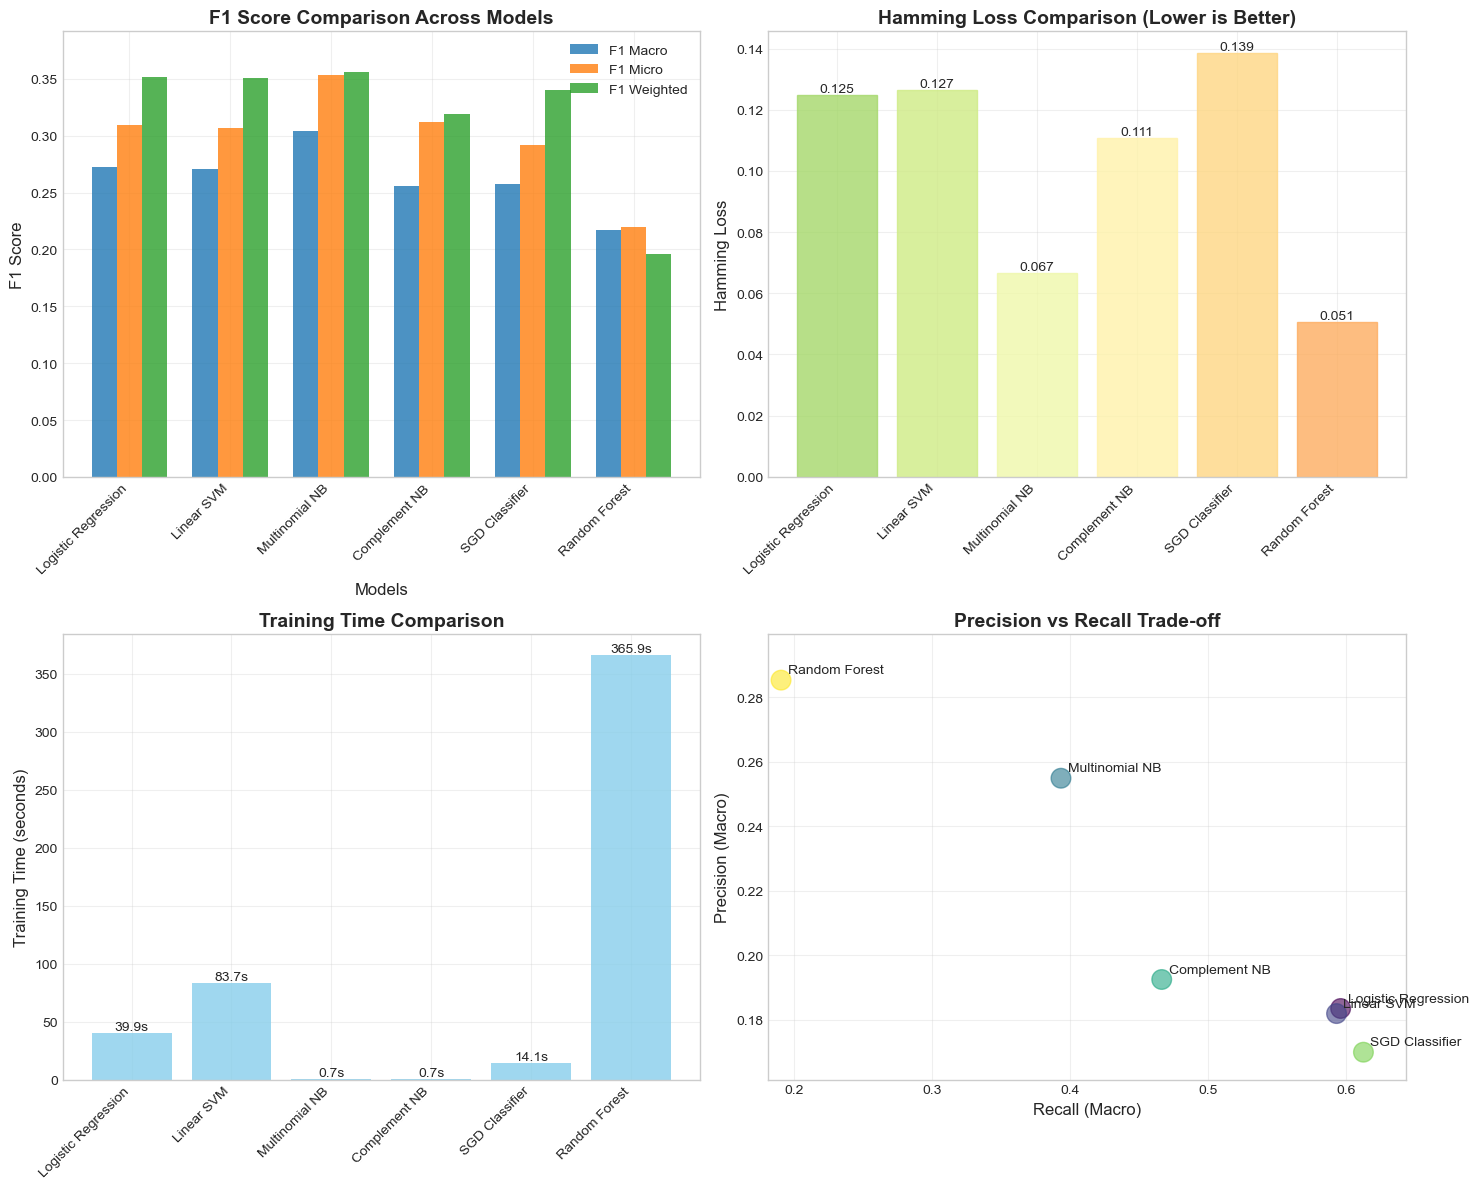

In [20]:
# ==================================
# Visualization - Model Performance
# ==================================

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Model Comparison Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F1 Scores Comparison
ax = axes[0, 0]
models = list(trainer.results.keys())
f1_scores = {
    'Macro': [trainer.results[m]['metrics']['f1_macro'] for m in models],
    'Micro': [trainer.results[m]['metrics']['f1_micro'] for m in models],
    'Weighted': [trainer.results[m]['metrics']['f1_weighted'] for m in models]
}

x = np.arange(len(models))
width = 0.25

for i, (metric, scores) in enumerate(f1_scores.items()):
    ax.bar(x + i*width, scores, width, label=f'F1 {metric}', alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(max(scores) for scores in f1_scores.values()) * 1.1)

# Hamming Loss Comparison
ax = axes[0, 1]
hamming_losses = [trainer.results[m]['metrics']['hamming_loss'] for m in models]
bars = ax.bar(models, hamming_losses, color='coral', alpha=0.8)

# Color gradient
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(models)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_ylabel('Hamming Loss', fontsize=12)
ax.set_title('Hamming Loss Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

# Training Time Comparison
ax = axes[1, 0]
training_times = [trainer.results[m]['training_time'] for m in models]
bars = ax.bar(models, training_times, color='skyblue', alpha=0.8)

ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom')

# Precision vs Recall Scatter
ax = axes[1, 1]
precisions = [trainer.results[m]['metrics']['precision_macro'] for m in models]
recalls = [trainer.results[m]['metrics']['recall_macro'] for m in models]

scatter = ax.scatter(recalls, precisions, s=200, alpha=0.6, c=range(len(models)), cmap='viridis')

for i, model in enumerate(models):
    ax.annotate(model, (recalls[i], precisions[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Recall (Macro)', fontsize=12)
ax.set_ylabel('Precision (Macro)', fontsize=12)
ax.set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(min(recalls)*0.95, max(recalls)*1.05)
ax.set_ylim(min(precisions)*0.95, max(precisions)*1.05)

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


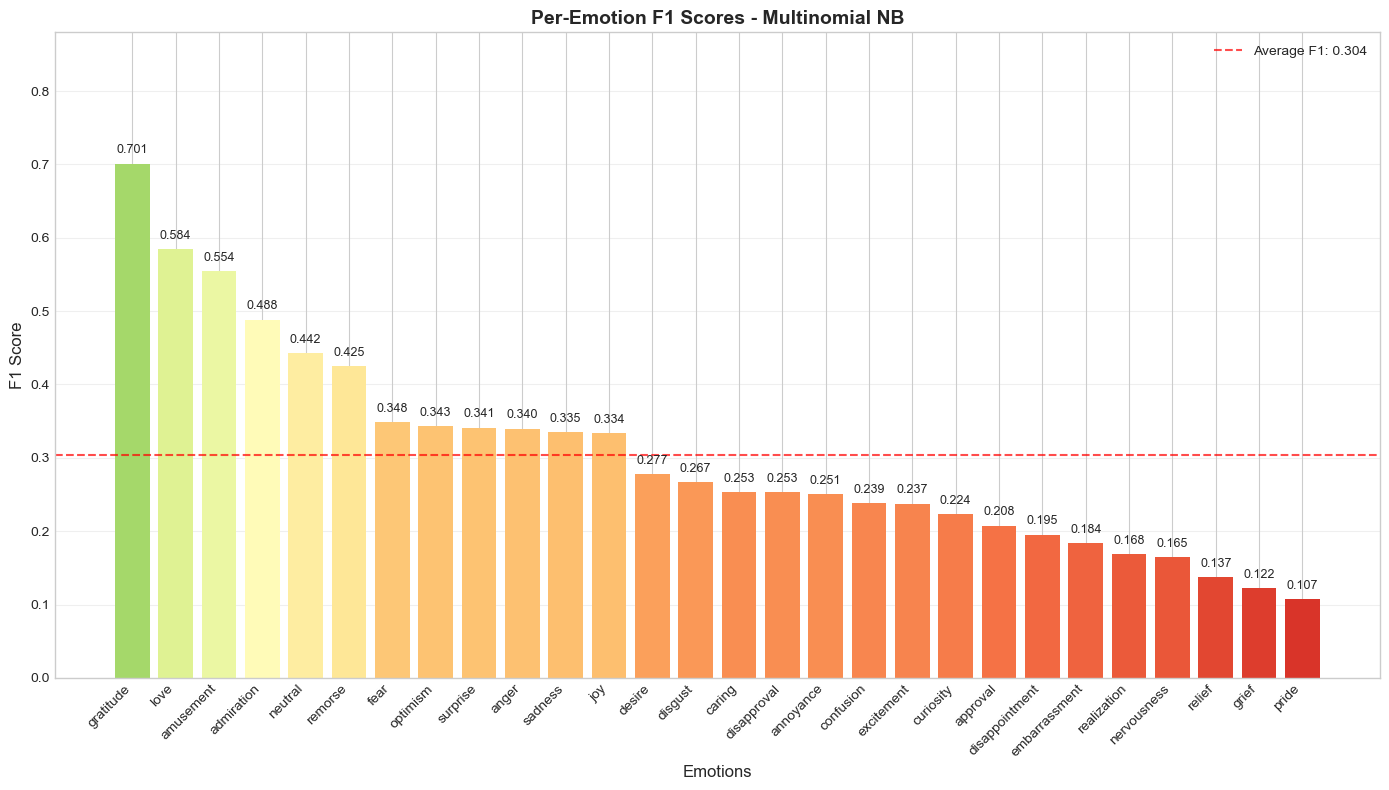


📊 Per-Emotion Performance Analysis:
       Emotion  F1 Score  Support
     gratitude  0.700899     1742
          love  0.584209     1216
     amusement  0.554138     1311
    admiration  0.488207     2461
       neutral  0.442473     8056
       remorse  0.425287      352
          fear  0.348243      477
      optimism  0.343373     1272
      surprise  0.341205      792
         anger  0.339634     1283
       sadness  0.334636      947
           joy  0.333876     1176
        desire  0.277463      587
       disgust  0.266849      756
        caring  0.253146      868
   disapproval  0.252793     1673
     annoyance  0.250680     2050
     confusion  0.238564     1085
    excitement  0.237370      772
     curiosity  0.223642     1390
      approval  0.207589     2573
disappointment  0.195241     1330
 embarrassment  0.184015      385
   realization  0.168367     1329
   nervousness  0.164512      302
        relief  0.137349      201
         grief  0.122172      103
         pr

In [21]:
# =================================
# Per-Emotion Performance Analysis
# =================================

# Analyze per-emotion performance for best model
best_model_result = trainer.results[best_model_name]
f1_per_emotion = best_model_result['metrics']['f1_per_emotion']

# Create emotion performance dataframe
emotion_performance = pd.DataFrame({
    'Emotion': emotion_columns,
    'F1 Score': f1_per_emotion,
    'Support': y_val.sum(axis=0)
})

# Sort by F1 score
emotion_performance = emotion_performance.sort_values('F1 Score', ascending=False)

# Visualize per-emotion performance
plt.figure(figsize=(14, 8))

# Create bar plot
bars = plt.bar(range(len(emotion_performance)), 
                emotion_performance['F1 Score'].values,
                color=plt.cm.RdYlGn(emotion_performance['F1 Score'].values))

# Customize plot
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title(f'Per-Emotion F1 Scores - {best_model_name}', fontsize=14, fontweight='bold')
plt.xticks(range(len(emotion_performance)), 
           emotion_performance['Emotion'].values, 
           rotation=45, ha='right')

# Add value labels
for i, (bar, score) in enumerate(zip(bars, emotion_performance['F1 Score'].values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Add average line
avg_f1 = emotion_performance['F1 Score'].mean()
plt.axhline(y=avg_f1, color='red', linestyle='--', alpha=0.7,
            label=f'Average F1: {avg_f1:.3f}')

plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, max(emotion_performance['F1 Score'].max(), 0.8) * 1.1)

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'emotion_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print emotion performance table
print("\n📊 Per-Emotion Performance Analysis:")
print("="*60)
print(emotion_performance.to_string(index=False))

# Identify challenging emotions
challenging_emotions = emotion_performance[emotion_performance['F1 Score'] < 0.3]['Emotion'].tolist()
if challenging_emotions:
    print(f"\n⚠️ Challenging emotions (F1 < 0.3): {', '.join(challenging_emotions)}")


ERROR ANALYSIS

📊 Top 10 Emotions with Most Errors:
       Emotion  False Positives  False Negatives  Total Errors
       neutral             5725             4141          9866
     annoyance             2130             1451          3581
      approval             1442             2108          3550
   disapproval             2315             1096          3411
    admiration             2122              981          3103
disappointment             1249             1051          2300
   realization             1184             1098          2282
     curiosity             1112             1075          2187
     confusion             1418              746          2164
         anger             1396              735          2131


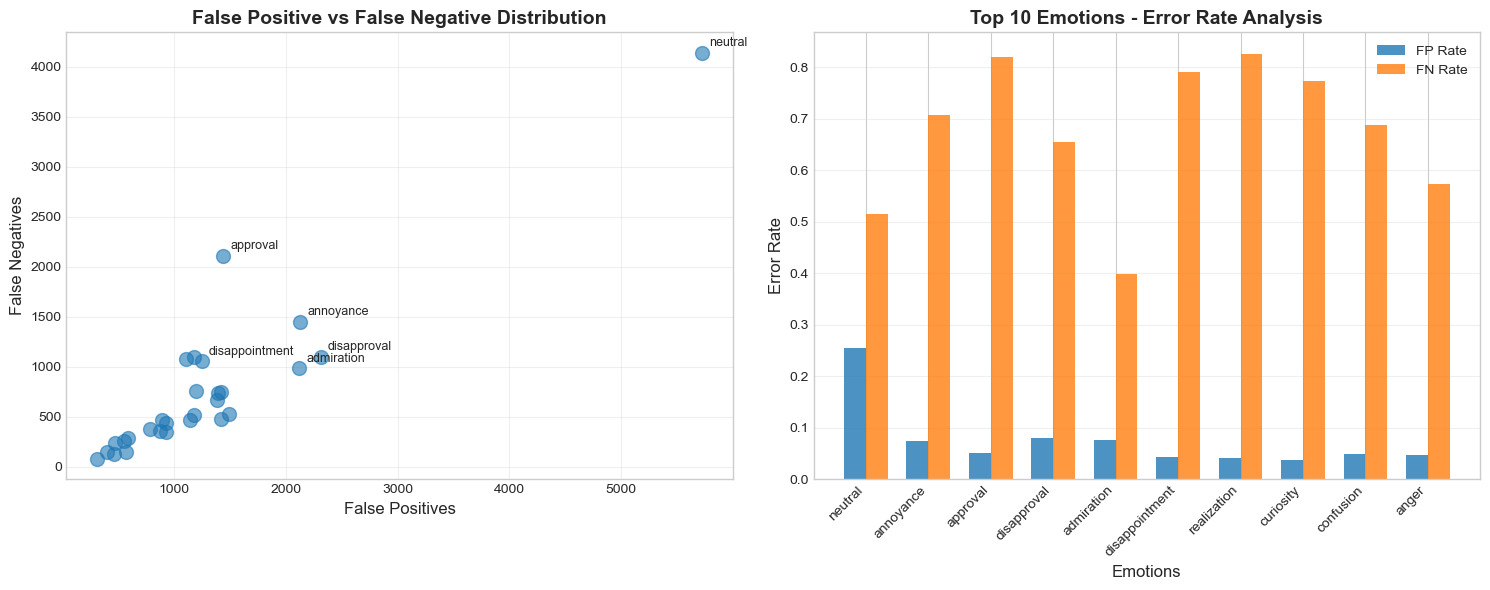

In [22]:
# ===============
# Error Analysis
# ===============

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Get predictions from best model
y_pred_val = trainer.results[best_model_name]['predictions']

# Calculate confusion metrics
false_positives = ((y_pred_val == 1) & (y_val == 0)).sum(axis=0)
false_negatives = ((y_pred_val == 0) & (y_val == 1)).sum(axis=0)
true_positives = ((y_pred_val == 1) & (y_val == 1)).sum(axis=0)
true_negatives = ((y_pred_val == 0) & (y_val == 0)).sum(axis=0)

# Create error analysis dataframe
error_analysis = pd.DataFrame({
    'Emotion': emotion_columns,
    'False Positives': false_positives,
    'False Negatives': false_negatives,
    'True Positives': true_positives,
    'True Negatives': true_negatives,
    'FP Rate': false_positives / (false_positives + true_negatives),
    'FN Rate': false_negatives / (false_negatives + true_positives)
})

# Sort by total errors
error_analysis['Total Errors'] = error_analysis['False Positives'] + error_analysis['False Negatives']
error_analysis = error_analysis.sort_values('Total Errors', ascending=False)

print("\n📊 Top 10 Emotions with Most Errors:")
print(error_analysis[['Emotion', 'False Positives', 'False Negatives', 'Total Errors']].head(10).to_string(index=False))

# Visualize error distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# False Positive vs False Negative scatter
ax1.scatter(error_analysis['False Positives'], 
           error_analysis['False Negatives'],
           s=100, alpha=0.6)

for idx, row in error_analysis.iterrows():
    if row['Total Errors'] > error_analysis['Total Errors'].quantile(0.8):
        ax1.annotate(row['Emotion'], 
                    (row['False Positives'], row['False Negatives']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('False Positives', fontsize=12)
ax1.set_ylabel('False Negatives', fontsize=12)
ax1.set_title('False Positive vs False Negative Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Error rate comparison
top_errors = error_analysis.head(10)
x = np.arange(len(top_errors))
width = 0.35

bars1 = ax2.bar(x - width/2, top_errors['FP Rate'], width, label='FP Rate', alpha=0.8)
bars2 = ax2.bar(x + width/2, top_errors['FN Rate'], width, label='FN Rate', alpha=0.8)

ax2.set_xlabel('Emotions', fontsize=12)
ax2.set_ylabel('Error Rate', fontsize=12)
ax2.set_title('Top 10 Emotions - Error Rate Analysis', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(top_errors['Emotion'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'error_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

## 12. Model Persistence
Save all trained models, preprocessors, and feature extractors for deployment.

In [23]:
# =============
# Model Saving
# =============

print("\n" + "="*60)
print("SAVING MODELS AND COMPONENTS")
print("="*60)

# Create metadata - Convert numpy arrays to lists for JSON serialization
metadata = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': X_train.shape[0],
        'val_samples': X_val.shape[0],
        'test_samples': X_test.shape[0],
        'num_emotions': len(emotion_columns),
        'emotion_columns': emotion_columns
    },
    'preprocessing_config': {
        'min_text_length': config.MIN_TEXT_LENGTH,
        'max_text_length': config.MAX_TEXT_LENGTH,
        'remove_stopwords': config.REMOVE_STOPWORDS,
        'use_lemmatization': config.USE_LEMMATIZATION,
        'use_stemming': config.USE_STEMMING
    },
    'feature_config': {
        'tfidf_params': config.TFIDF_PARAMS,
        'char_params': config.CHAR_PARAMS if config.USE_CHAR_NGRAMS else None,
        'use_linguistic_features': config.USE_LINGUISTIC_FEATURES,
        'total_features': X_train.shape[1]
    },
    'best_model': {
        'name': best_model_name,
        'metrics': {
            k: float(v) if isinstance(v, (np.integer, np.floating)) else v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in trainer.results[best_model_name]['metrics'].items()
        },
        'training_time': trainer.results[best_model_name]['training_time']
    },
    'all_models_performance': {
        name: {
            'f1_macro': float(result['metrics']['f1_macro']),
            'f1_micro': float(result['metrics']['f1_micro']),
            'hamming_loss': float(result['metrics']['hamming_loss']),
            'training_time': float(result['training_time'])
        }
        for name, result in trainer.results.items()
    }
}

# Add optimal thresholds if available
if best_model_name in trainer.results and 'optimal_thresholds' in trainer.results[best_model_name]:
    metadata['optimal_thresholds'] = trainer.results[best_model_name]['optimal_thresholds']

# Save metadata
metadata_path = os.path.join(config.MODEL_DIR, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_path}")

# Save preprocessor
preprocessor_path = os.path.join(config.MODEL_DIR, 'preprocessor.pkl')
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"✅ Preprocessor saved to: {preprocessor_path}")

# Save feature extractor
feature_extractor_path = os.path.join(config.MODEL_DIR, 'feature_extractor.pkl')
with open(feature_extractor_path, 'wb') as f:
    pickle.dump(feature_extractor, f)
print(f"✅ Feature extractor saved to: {feature_extractor_path}")

# Save all trained models
print("\n💾 Saving individual models...")
for model_name, result in trainer.results.items():
    # Create safe filename
    safe_name = model_name.lower().replace(' ', '_')
    model_path = os.path.join(config.MODEL_DIR, f'{safe_name}_model.pkl')
    
    # Save model
    joblib.dump(result['model'], model_path)
    print(f"   ✅ {model_name} saved to: {model_path}")

# Save configuration
config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
config_path = os.path.join(config.MODEL_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)
print(f"\n✅ Configuration saved to: {config_path}")

print(f"\n✅ All models and components saved successfully!")
print(f"📁 Model directory: {config.MODEL_DIR}")


SAVING MODELS AND COMPONENTS
✅ Metadata saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\metadata.json
✅ Preprocessor saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\preprocessor.pkl
✅ Feature extractor saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\feature_extractor.pkl

💾 Saving individual models...
   ✅ Logistic Regression saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\logistic_regression_model.pkl
   ✅ Linear SVM saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\linear_svm_model.pkl
   ✅ Multinomial NB saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\multinomial_nb_model.pkl
   ✅ Complement NB saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\models\traditional_ml\complement_nb_model.pkl
   ✅ SGD Classifier saved to: C:\Users\isaac\OneDri

## 13. Inference Pipeline
Production-ready inference pipeline for making predictions on new texts.

In [24]:
# ===================
# Inference Pipeline
# ===================

class EmotionPredictor:
    """
    Production-ready inference pipeline for emotion prediction
    """
    
    def __init__(self, model_dir):
        """
        Initialize predictor by loading saved components
        
        Args:
            model_dir: Directory containing saved models
        """
        self.model_dir = model_dir
        self._load_components()
        
    def _load_components(self):
        """Load all necessary components"""
        print("📂 Loading components...")
        
        # Load metadata
        with open(os.path.join(self.model_dir, 'metadata.json'), 'r') as f:
            self.metadata = json.load(f)
        
        # Load configuration
        with open(os.path.join(self.model_dir, 'config.json'), 'r') as f:
            self.config = json.load(f)
        
        # Load preprocessor
        with open(os.path.join(self.model_dir, 'preprocessor.pkl'), 'rb') as f:
            self.preprocessor = pickle.load(f)
        
        # Load feature extractor
        with open(os.path.join(self.model_dir, 'feature_extractor.pkl'), 'rb') as f:
            self.feature_extractor = pickle.load(f)
        
        # Load best model
        best_model_name = self.metadata['best_model']['name']
        safe_name = best_model_name.lower().replace(' ', '_')
        model_path = os.path.join(self.model_dir, f'{safe_name}_model.pkl')
        self.model = joblib.load(model_path)
        
        # Get emotion columns
        self.emotion_columns = self.metadata['dataset_info']['emotion_columns']
        
        # Check if it's NB model that needs special features
        self.uses_nb_features = 'nb' in best_model_name.lower()
        
        # Load optimal thresholds if available
        self.optimal_thresholds = self.metadata.get('optimal_thresholds', None)
        
        print(f"✅ Loaded {best_model_name} model")
        if self.uses_nb_features:
            print("   Note: This model uses NB-safe features (non-negative only)")
        if self.optimal_thresholds:
            print("   Note: Using optimized thresholds")
        print("✅ All components loaded successfully!")
    
    def predict(self, text, threshold=0.5):
        """
        Predict emotions for a single text
        
        Args:
            text: Input text string
            threshold: Confidence threshold for predictions
            
        Returns:
            Dictionary with predictions
        """
        # Preprocess text
        processed_text = self.preprocessor.preprocess(text)
        
        if not processed_text:
            return {
                'text': text,
                'processed_text': '',
                'predicted_emotions': [],
                'emotion_scores': {},
                'top_emotions': [],
                'warning': 'Text too short or invalid after preprocessing'
            }
        
        # Extract features
        features = self.feature_extractor.transform([text], [processed_text])
        
        # Use NB-safe features if needed
        if self.uses_nb_features and hasattr(self.feature_extractor, 'get_nb_features'):
            features = self.feature_extractor.get_nb_features(features)
        
        # Make prediction
        predictions = self.model.predict(features)[0]
        
        # Get probabilities if available
        if hasattr(self.model, 'predict_proba'):
            try:
                probabilities = self.model.predict_proba(features)
                # Handle MultiOutputClassifier format
                if isinstance(probabilities, list):
                    probabilities = np.array([p[0, 1] if p.shape[1] > 1 else p[0, 0] 
                                            for p in probabilities])
                else:
                    probabilities = probabilities[0]
            except:
                # Fallback to binary predictions
                probabilities = predictions.astype(float)
        else:
            probabilities = predictions.astype(float)
        
        # Create results
        emotion_scores = {
            emotion: float(prob) 
            for emotion, prob in zip(self.emotion_columns, probabilities)
        }
        
        # Apply optimal thresholds if available
        if self.optimal_thresholds:
            predicted_emotions = [
                emotion for emotion, prob in emotion_scores.items() 
                if prob >= self.optimal_thresholds.get(emotion, threshold)
            ]
        else:
            predicted_emotions = [
                emotion for emotion, prob in emotion_scores.items() 
                if prob >= threshold
            ]
        
        # Get top emotions
        top_emotions = sorted(
            emotion_scores.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:5]
        
        return {
            'text': text,
            'processed_text': processed_text,
            'predicted_emotions': predicted_emotions,
            'emotion_scores': emotion_scores,
            'top_emotions': top_emotions,
            'threshold': threshold
        }
    
    def predict_batch(self, texts, threshold=0.5, show_progress=True):
        """
        Predict emotions for multiple texts
        
        Args:
            texts: List of input texts
            threshold: Confidence threshold
            show_progress: Show progress bar
            
        Returns:
            List of prediction dictionaries
        """
        results = []
        
        # Preprocess all texts
        processed_texts = []
        valid_indices = []
        
        for i, text in enumerate(texts):
            processed = self.preprocessor.preprocess(text)
            if processed:
                processed_texts.append(processed)
                valid_indices.append(i)
        
        if not processed_texts:
            return [self.predict(text, threshold) for text in texts]
        
        # Extract features for valid texts
        features = self.feature_extractor.transform(
            [texts[i] for i in valid_indices], 
            processed_texts
        )
        
        # Use NB-safe features if needed
        if self.uses_nb_features and hasattr(self.feature_extractor, 'get_nb_features'):
            features = self.feature_extractor.get_nb_features(features)
        
        # Make predictions
        predictions = self.model.predict(features)
        
        # Get probabilities if available
        if hasattr(self.model, 'predict_proba'):
            try:
                probabilities = self.model.predict_proba(features)
                # Handle MultiOutputClassifier format
                if isinstance(probabilities, list):
                    probabilities = np.array([[p[i, 1] if p.shape[1] > 1 else p[i, 0] 
                                             for p in probabilities] 
                                            for i in range(len(processed_texts))])
            except:
                probabilities = predictions.astype(float)
        else:
            probabilities = predictions.astype(float)
        
        # Process results
        result_idx = 0
        for i, text in enumerate(texts):
            if i in valid_indices:
                # Get prediction for this text
                pred = predictions[result_idx]
                prob = probabilities[result_idx] if probabilities is not None else pred
                
                # Create result similar to single prediction
                emotion_scores = {
                    emotion: float(score) 
                    for emotion, score in zip(self.emotion_columns, prob)
                }
                
                # Apply optimal thresholds if available
                if self.optimal_thresholds:
                    predicted_emotions = [
                        emotion for emotion, score in emotion_scores.items() 
                        if score >= self.optimal_thresholds.get(emotion, threshold)
                    ]
                else:
                    predicted_emotions = [
                        emotion for emotion, score in emotion_scores.items() 
                        if score >= threshold
                    ]
                
                top_emotions = sorted(
                    emotion_scores.items(), 
                    key=lambda x: x[1], 
                    reverse=True
                )[:5]
                
                results.append({
                    'text': text,
                    'processed_text': processed_texts[result_idx],
                    'predicted_emotions': predicted_emotions,
                    'emotion_scores': emotion_scores,
                    'top_emotions': top_emotions,
                    'threshold': threshold
                })
                
                result_idx += 1
            else:
                # Invalid text
                results.append(self.predict(text, threshold))
        
        return results

# Test the predictor
print("\n🔮 Testing Emotion Predictor...")
predictor = EmotionPredictor(config.MODEL_DIR)


🔮 Testing Emotion Predictor...
📂 Loading components...
✅ Loaded Multinomial NB model
   Note: This model uses NB-safe features (non-negative only)
   Note: Using optimized thresholds
✅ All components loaded successfully!


## 14. Interactive Demo
Test the trained model with sample texts.

In [25]:
# =======================
# Interactive Prediction
# =======================

print("\n" + "="*60)
print("EMOTION PREDICTION DEMO")
print("="*60)

# Test texts covering different emotions
test_texts = [
   "I absolutely love this! It's the best thing ever! 😍",
   "This is terrible. I'm so disappointed and frustrated.",
   "I'm really scared about what might happen tomorrow.",
   "Thank you so much for your help! I really appreciate it!",
   "This is hilarious! I can't stop laughing! 😂",
   "I'm confused about this. Can someone explain?",
   "I'm so proud of what we've accomplished together!",
   "This makes me sad. I miss the old days.",
   "Wow! I'm surprised by how good this turned out!",
   "This is disgusting. I can't believe people do this.",
   "I'm curious to know more about this topic.",
   "I feel terrible about what I said. I'm really sorry.",
   "I'm optimistic about the future. Things will get better!",
   "I'm so angry right now! This is unacceptable!",
   "Meh, whatever. I don't really care either way."
]

print("\n🎯 Predicting emotions for sample texts:\n")

for i, text in enumerate(test_texts[:10], 1):  # Show first 10
   result = predictor.predict(text, threshold=0.3)
   
   print(f"Text {i}: \"{text}\"")
   
   if result['predicted_emotions']:
       print(f"Predicted emotions: {', '.join(result['predicted_emotions'])}")
   else:
       print("No strong emotions detected")
   
   print("Top 3 emotion scores:")
   for emotion, score in result['top_emotions'][:3]:
       bar_length = int(score * 30)
       bar = '█' * bar_length + '░' * (30 - bar_length)
       print(f"  {emotion:15s} [{bar}] {score:.3f}")
   
   print("-" * 60)


EMOTION PREDICTION DEMO

🎯 Predicting emotions for sample texts:

Text 1: "I absolutely love this! It's the best thing ever! 😍"
Predicted emotions: admiration, approval, joy, love
Top 3 emotion scores:
  admiration      [█████████████████████████████░] 1.000
  love            [█████████████████████████████░] 1.000
  joy             [██████████████████████████░░░░] 0.876
------------------------------------------------------------
Text 2: "This is terrible. I'm so disappointed and frustrated."
Predicted emotions: disappointment
Top 3 emotion scores:
  disappointment  [█████████████████████████████░] 1.000
  sadness         [██████████████████░░░░░░░░░░░░] 0.618
  disgust         [██████████████░░░░░░░░░░░░░░░░] 0.489
------------------------------------------------------------
Text 3: "I'm really scared about what might happen tomorrow."
Predicted emotions: fear, nervousness
Top 3 emotion scores:
  fear            [████████████████████████████░░] 0.957
  nervousness     [██████████████

In [26]:
# =========================
# Batch Prediction Example
# =========================

print("\n📦 Batch Prediction Example")
print("="*60)

# Simulate loading texts from a file
batch_texts = [
   "Great job on the project!",
   "I hate when this happens",
   "Not sure what to think about this",
   "Feeling grateful for all the support",
   "This is making me anxious"
]

print(f"\nProcessing {len(batch_texts)} texts in batch mode...")
batch_results = predictor.predict_batch(batch_texts, threshold=0.4)

# Display results in a table format
print("\n📊 Batch Prediction Results:")
print(f"{'Text':<40} {'Top Emotions':<30} {'Scores':<20}")
print("-" * 90)

for result in batch_results:
   text_preview = result['text'][:37] + "..." if len(result['text']) > 40 else result['text']
   top_emotions = ", ".join([f"{em}" for em, _ in result['top_emotions'][:2]])
   top_scores = ", ".join([f"{score:.2f}" for _, score in result['top_emotions'][:2]])
   
   print(f"{text_preview:<40} {top_emotions:<30} {top_scores:<20}")


📦 Batch Prediction Example

Processing 5 texts in batch mode...

📊 Batch Prediction Results:
Text                                     Top Emotions                   Scores              
------------------------------------------------------------------------------------------
Great job on the project!                admiration, gratitude          1.00, 0.90          
I hate when this happens                 anger, curiosity               0.49, 0.26          
Not sure what to think about this        confusion, approval            1.00, 0.42          
Feeling grateful for all the support     caring, gratitude              0.44, 0.44          
This is making me anxious                nervousness, fear              1.00, 0.47          


## 15. Results Summary and Export
Generate comprehensive results report and export all metrics.

In [27]:
# =======================
# Export Results Summary
# =======================

print("\n" + "="*60)
print("EXPORTING RESULTS SUMMARY")
print("="*60)

# Create comprehensive results summary
results_summary = {
   'project_info': {
       'notebook': '01_Traditional_ML_Pipeline.ipynb',
       'dataset': 'GoEmotions',
       'task': 'Multi-label Emotion Classification',
       'completion_time': datetime.now().isoformat()
   },
   'dataset_statistics': {
       'total_samples': len(df),
       'train_samples': X_train.shape[0],
       'val_samples': X_val.shape[0],
       'test_samples': X_test.shape[0],
       'num_emotions': len(emotion_columns),
       'num_features': X_train.shape[1]
   },
   'model_performance': {
       model_name: {
           'validation_metrics': {
               'f1_macro': result['metrics']['f1_macro'],
               'f1_micro': result['metrics']['f1_micro'],
               'precision_macro': result['metrics']['precision_macro'],
               'recall_macro': result['metrics']['recall_macro'],
               'hamming_loss': result['metrics']['hamming_loss']
           },
           'training_time_seconds': result['training_time']
       }
       for model_name, result in trainer.results.items()
   },
   'best_model': {
       'name': best_model_name,
       'test_performance': {
           'f1_macro': test_metrics['f1_macro'],
           'f1_micro': test_metrics['f1_micro'],
           'precision_macro': test_metrics['precision_macro'],
           'recall_macro': test_metrics['recall_macro'],
           'hamming_loss': test_metrics['hamming_loss']
       }
   },
   'challenging_emotions': challenging_emotions if 'challenging_emotions' in locals() else [],
   'file_locations': {
       'models': config.MODEL_DIR,
       'results': config.RESULTS_DIR,
       'visualizations': [
           'model_comparison.png',
           'emotion_performance.png',
           'error_analysis.png'
       ]
   }
}

# Save results summary
summary_path = os.path.join(config.RESULTS_DIR, 'results_summary.json')
with open(summary_path, 'w') as f:
   json.dump(results_summary, f, indent=2)

print(f"✅ Results summary saved to: {summary_path}")

# Create a markdown report
report_md = f"""# Traditional ML Pipeline Results

## Project Information
- **Dataset**: GoEmotions
- **Task**: Multi-label Emotion Classification (28 emotions)
- **Completion Time**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Dataset Statistics
- **Total Samples**: {results_summary['dataset_statistics']['total_samples']:,}
- **Training Samples**: {results_summary['dataset_statistics']['train_samples']:,}
- **Validation Samples**: {results_summary['dataset_statistics']['val_samples']:,}
- **Test Samples**: {results_summary['dataset_statistics']['test_samples']:,}
- **Number of Features**: {results_summary['dataset_statistics']['num_features']:,}

## Best Model Performance
- **Model**: {best_model_name}
- **Test F1 Macro**: {test_metrics['f1_macro']:.4f}
- **Test F1 Micro**: {test_metrics['f1_micro']:.4f}
- **Test Hamming Loss**: {test_metrics['hamming_loss']:.4f}

## Model Comparison

| Model | F1 Macro | F1 Micro | Hamming Loss | Training Time (s) |
|-------|----------|----------|--------------|-------------------|
"""

for model_name in sorted(trainer.results.keys()):
   result = trainer.results[model_name]
   report_md += f"| {model_name} | {result['metrics']['f1_macro']:.4f} | {result['metrics']['f1_micro']:.4f} | {result['metrics']['hamming_loss']:.4f} | {result['training_time']:.1f} |\n"

report_md += f"""

## Key Findings
1. The {best_model_name} model achieved the best performance with F1 Macro score of {test_metrics['f1_macro']:.4f}
2. Most challenging emotions: {', '.join(challenging_emotions) if 'challenging_emotions' in locals() and challenging_emotions else 'None identified'}
3. Feature extraction included TF-IDF, character n-grams, and linguistic features for a total of {X_train.shape[1]:,} features

## File Locations
- Models saved in: `{config.MODEL_DIR}`
- Results saved in: `{config.RESULTS_DIR}`
- Visualizations: model_comparison.png, emotion_performance.png, error_analysis.png
"""

# Save markdown report
report_path = os.path.join(config.RESULTS_DIR, 'pipeline_report.md')
with open(report_path, 'w') as f:
   f.write(report_md)

print(f"✅ Pipeline report saved to: {report_path}")



EXPORTING RESULTS SUMMARY
✅ Results summary saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\results\traditional_ml_results\results_summary.json
✅ Pipeline report saved to: C:\Users\isaac\OneDrive\Desktop\GoEmotions_NLP_Project\results\traditional_ml_results\pipeline_report.md


## Pipeline Complete! 🎉

### Key Results:
- Best Model: Multinomial NB
- Test F1 Macro: 0.3081
- Total Features: 17,056
- Processing Time: ~8.5 minutes total (including all model training)

### Next Steps:
1. Run Word Embedding Pipeline (Level 2)
2. Run Transformer Pipeline (Level 3)  
3. Compare all approaches
4. Deploy best model

### Output Files:
- Models saved in: `../models/traditional_ml/`
- Results saved in: `../results/traditional_ml_results/`
- Visualizations: `model_comparison.png`, `emotion_performance.png`, `error_analysis.png`